In [1]:
# These are all the modules we'll be using later. Make sure you can import them
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import json
from six.moves.urllib.request import urlretrieve
debug = False

In [2]:
url = 'http://orange.com/wgmn4901/data/'
data_dir = "../data/"

In [3]:
# list of current snapshots in data folder
!echo "Available data:"
path = os.path.abspath(data_dir)
!ls -l $path | grep "tar.gz"

"Available data:"


'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [4]:
import time, sys

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    try: 
        sys.stdout.write(text)
        sys.stdout.flush()
    except ValueError as e:
        print(e)

In [5]:
from shutil import copyfile
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    if os.path.exists(data_dir+filename):
      #copy from data folder to working directory
      copyfile(data_dir+filename, filename)
    else:
      filename, _ = urlretrieve(url + filename, filename) # may not work as expected
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

clustersnapshot = maybe_download('OrangeOneWeekLogs.7z', 125323974)

Found and verified OrangeOneWeekLogs.7z


In [6]:
def maybe_extract(filename,force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  #print('Found the following application profile in %s:' % filename)
  #for folder in data_folders:
  #  print ('  %s' % folder)
  return data_folders
  
clustersnapshot_folders = maybe_extract(clustersnapshot)

OrangeOneWeekLogs already present - Skipping extraction of OrangeOneWeekLogs.7z.


In [7]:
import pandas as pd #this is how I usually import pandas

def load_application(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_type_list = []
  container_task_list = []
  container_node_list = []
  container_node_mem_total_list = []
  container_node_CPU_total_list = []
  container_node_mem_rsrv_list = []
  container_node_CPU_rsrv_list = []
  container_mem_assigned_list = []
  container_CPU_assigned_list = []
  appId_list = [] #this one should be call appId
  appname_list = []
  appowner_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_type = data["application_info"]["appType"] #First task only
        appId = data["application_info"]["appId"]
        appname = data["application_info"]["appName"]
        appowner = data["application_info"]["appOwner"]
        if not data["nodeInfo"]:
            container_node = "null"
            container_node_mem_total = 0
            container_node_CPU_total = 0
            container_node_mem_rsrv = 0
            container_node_CPU_rsrv = 0
            container_mem_assigned = 0
            container_CPU_assigned = 0
        else:
            container_node = data["nodeInfo"]["id"]
            container_node_mem_total = data["nodeInfo"]["totalNodePhyMem"]
            container_node_CPU_total = data["nodeInfo"]["totalNodePhyCore"]
            container_node_mem_rsrv = data["nodeInfo"]["totalPmemAllocatedContainersMB"] * 1024
            container_node_CPU_rsrv = data["nodeInfo"]["totalVCoresAllocatedContainers"]
            container_mem_assigned = data["MemoryAssignedMB"] * 1024
            container_CPU_assigned = data["VCoresAssigned"]
        if not data["container_tasks"]:
            container_task = "null"
        else:
            container_task = data["container_tasks"][0]["task_type"]
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_type_list.insert(container_index,container_type)
        container_task_list.insert(container_index,container_task)
        container_node_list.insert(container_index,container_node)
        container_node_mem_total_list.insert(container_index,container_node_mem_total)
        container_node_CPU_total_list.insert(container_index,container_node_CPU_total)
        container_node_mem_rsrv_list.insert(container_index,container_node_mem_rsrv)
        container_node_CPU_rsrv_list.insert(container_index,container_node_CPU_rsrv)
        container_mem_assigned_list.insert(container_index,container_mem_assigned)
        container_CPU_assigned_list.insert(container_index,container_CPU_assigned)
        appId_list.insert(container_index,appId)
        appname_list.insert(container_index,appname)
        appowner_list.insert(container_index,appowner)
      #if not container_name:
      #  raise Exception('Unexpected container name')
      #if container_starttime == 0:
      #  raise Exception('Unexpected container start time')
      #if container_endtime == 0:
      #  raise Exception('Unexpected container end time')
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(container_starttime_list,container_endtime_list,
                     container_type_list,container_task_list,container_node_list,container_node_mem_total_list,
                     container_node_CPU_total_list,container_node_mem_rsrv_list,container_node_CPU_rsrv_list,
                     container_mem_assigned_list, container_CPU_assigned_list, appId_list, appname_list, appowner_list))
  columns=[ 'start', 'end', 'type', 'task', 'node','n_mem','n_CPU',
                                    'mem_rsrv','CPU_rsrv','mem','CPU','app','appname', 'appowner']
  DataFrame = pd.DataFrame(data = DataSet, index=container_name_list,
                           columns=columns)
  return DataFrame, application_starttime, application_endtime

def load_snapshot(snapshot_folders):
  snapshot_starttime = 100000000000000 # really big number
  snapshot_endtime = 0
  snapshot_dataframe = pd.DataFrame()
  for application_folder in snapshot_folders: 
    dataframe, application_starttime, application_endtime = load_application(application_folder)
    if application_starttime < snapshot_starttime:
      snapshot_starttime = application_starttime
    if application_endtime > snapshot_endtime:
      snapshot_endtime = application_endtime
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
  return snapshot_dataframe, snapshot_starttime, snapshot_endtime

snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))
snapshot_dataframe.head(n=5)

Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_10877_json\container_e88_1467203595416_10877_01_000006.jsonprofile : Expecting , delimiter: line 1 column 20970 (char 20969)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11083_json\container_e88_1467203595416_11083_01_000001.jsonprofile : Expecting , delimiter: line 1 column 20596 (char 20595)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11619_json\container_e88_1467203595416_11619_01_000001.jsonprofile : Expecting , delimiter: line 1 column 76650 (char 76649)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_12320_json\container_e88_1467203595416_12320_01_000002.jsonprofile : Expecting , delimiter: line 1 column 694036 (char 694035)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_5877_json\container_e88_1467203595416_5877_01_000004.jsonprofile : Expecting , delimiter: line 1 column 32862 (char 32861)
Wrong

start           end  \
container_e88_1467203595416_10000_01_000001  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10000_01_000002  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10001_01_000001  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10001_01_000002  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10002_01_000001  1.467809e+12  1.467809e+12   

                                                  type task  \
container_e88_1467203595416_10000_01_000001  MAPREDUCE   AM   
container_e88_1467203595416_10000_01_000002  MAPREDUCE  MAP   
container_e88_1467203595416_10001_01_000001  MAPREDUCE   AM   
container_e88_1467203595416_10001_01_000002  MAPREDUCE  MAP   
container_e88_1467203595416_10002_01_000001  MAPREDUCE   AM   

                                                                                          node  \
container_e88_1467203595416_10000_01_000001  datanode002.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_10000_01_000002  datanode004.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_10001_01_000001  datanode003.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_10001_01_000002  datanode003.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_10002_01_000001  datanode005.current.rec.mapreduce.m1.p.fti.net...   

                                                  n_mem  n_CPU    mem_rsrv  \
container_e88_1467203595416_10000_01_000001  66058808.0   24.0  56623104.0   
container_e88_1467203595416_10000_01_000002  66058808.0   24.0  56623104.0   
container_e88_1467203595416_10001_01_000001  66058808.0   24.0  56623104.0   
container_e88_1467203595416_10001_01_000002  66058808.0   24.0  56623104.0   
container_e88_1467203595416_10002_01_000001  66058808.0   24.0  56623104.0   

                                             CPU_rsrv        mem  CPU  \
container_e88_1467203595416_10000_01_000001      24.0  2097152.0  1.0   
container_e88_1467203595416_10000_01_000002      24.0  2097152.0  1.0   
container_e88_1467203595416_10001_01_000001      24.0  2097152.0  1.0   
container_e88_1467203595416_10001_01_000002      24.0  2097152.0  1.0   
container_e88_1467203595416_10002_01_000001      24.0  2097152.0  1.0   

                                                                         app  \
container_e88_1467203595416_10000_01_000001  application_1467203595416_10000   
container_e88_1467203595416_10000_01_000002  application_1467203595416_10000   
container_e88_1467203595416_10001_01_000001  application_1467203595416_10001   
container_e88_1467203595416_10001_01_000002  application_1467203595416_10001   
container_e88_1467203595416_10002_01_000001  application_1467203595416_10002   

                                                                                       appname  \
container_e88_1467203595416_10000_01_000001  oozie:launcher:T=sqoop:W=Gstat_w1_import_conf_...   
container_e88_1467203595416_10000_01_000002  oozie:launcher:T=sqoop:W=Gstat_w1_import_conf_...   
container_e88_1467203595416_10001_01_000001  oozie:action:T=sqoop:W=Gstat_w1_import_conf_ax...   
container_e88_1467203595416_10001_01_000002  oozie:action:T=sqoop:W=Gstat_w1_import_conf_ax...   
container_e88_1467203595416_10002_01_000001  oozie:launcher:T=sqoop:W=Gstat_w1_import_conf_...   

                                                appowner  
container_e88_1467203595416_10000_01_000001  gstathadoop  
container_e88_1467203595416_10000_01_000002  gstathadoop  
container_e88_1467203595416_10001_01_000001  gstathadoop  
container_e88_1467203595416_10001_01_000002  gstathadoop  
container_e88_1467203595416_10002_01_000001  gstathadoop

In [8]:
SnapshotDataFrame = snapshot_dataframe.sort_values(by="node")

print('Distribution of container on nodes:')
SnapshotDataFrame.groupby('node').count().app

Distribution of container on nodes:


node
datanode001.current.rec.mapreduce.m1.p.fti.net:45454    18576
datanode002.current.rec.mapreduce.m1.p.fti.net:45454    18652
datanode003.current.rec.mapreduce.m1.p.fti.net:45454    18793
datanode004.current.rec.mapreduce.m1.p.fti.net:45454    17898
datanode005.current.rec.mapreduce.m1.p.fti.net:45454    18308
datanode006.current.rec.mapreduce.m1.p.fti.net:45454    18530
Name: app, dtype: int64

In [9]:
SnapshotDataFrame = snapshot_dataframe.sort_values(by="app")
a, b, c, d = SnapshotDataFrame.app.describe()
print("total containers: %d" % a)
print("total jobs: %d" % b)
print("job has the most containers is %s with %d containers" % (c,d))

total containers: 110757
total jobs: 7990
job has the most containers is application_1467203595416_11633 with 846 containers


In [10]:
def load_application_cpu_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_load_list = []
  cpu_us_list = []
  cpu_sys_list = []
  cpu_id_list = []
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["cpu_usage"]:
          #print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["cpu_usage"]:
            container_capture_time = record["capture_time"]
            container_load = record["container_load"] / 100
            cpu_us = record["cpu_us"]
            cpu_sys = record["cpu_sy"]
            cpu_id = record["cpu_id"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_load_list.insert(record_index,container_load)
            cpu_us_list.insert(record_index,cpu_us)
            cpu_sys_list.insert(record_index,cpu_sys)
            cpu_id_list.insert(record_index,cpu_id)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_load_list,cpu_us_list,cpu_sys_list,cpu_id_list))
  columns=[ 'timestamp','name','cpu_load', 'cpu_us', 'cpu_sys', 'cpu_id']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_cpu_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_cpu_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe, snapshot_failcount

snapshot_cpu_profile, snapshot_failcount = load_snapshot_cpu_profile(clustersnapshot_folders)
print("There are %d containers having no information on the resource usage, we omit them" % snapshot_failcount)
snapshot_cpu_profile.head(n=5)

Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_10877_json\container_e88_1467203595416_10877_01_000006.jsonprofile : Expecting , delimiter: line 1 column 20970 (char 20969)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11083_json\container_e88_1467203595416_11083_01_000001.jsonprofile : Expecting , delimiter: line 1 column 20596 (char 20595)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11619_json\container_e88_1467203595416_11619_01_000001.jsonprofile : Expecting , delimiter: line 1 column 76650 (char 76649)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_12320_json\container_e88_1467203595416_12320_01_000002.jsonprofile : Expecting , delimiter: line 1 column 694036 (char 694035)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_5877_json\container_e88_1467203595416_5877_01_000004.jsonprofile : Expecting , delimiter: line 1 column 32862 (char 32861)
Wrong

timestamp                                         name  cpu_load  \
0  1.467809e+09  container_e88_1467203595416_10000_01_000001     3.558   
1  1.467809e+09  container_e88_1467203595416_10000_01_000001     2.018   
2  1.467809e+09  container_e88_1467203595416_10000_01_000001     3.087   
3  1.467809e+09  container_e88_1467203595416_10000_01_000001     4.385   
4  1.467809e+09  container_e88_1467203595416_10000_01_000001     4.156   

   cpu_us  cpu_sys  cpu_id  
0     9.6      1.2    89.0  
1    40.6      2.6    56.7  
2    34.7      2.1    63.1  
3    31.2      1.5    67.1  
4    30.8      2.0    67.1

In [11]:
snapshot_duration = snapshot_endtime - snapshot_starttime
snapshot_dataframe_remain = snapshot_dataframe[snapshot_dataframe.end == 0 ]
print("Removing %d containers which was not actually scheduled on the cluster" % len(snapshot_dataframe_remain) )
snapshot_dataframe = snapshot_dataframe[snapshot_dataframe.end != 0 ]
SnapshotDFSorted = snapshot_dataframe.sort_values(by="start")

Removing 752 containers which was not actually scheduled on the cluster


In [12]:
def get_cpu_actual_use(container_name, snapshot_dataframe, snapshot_cpu_profile):
    container_starttime = snapshot_dataframe.loc[container_name,'start']
    container_endtime = snapshot_dataframe.loc[container_name,'end']
    rescaled_container_starttime = container_starttime / 1000
    rescaled_container_endtime = container_endtime / 1000
    duration = rescaled_container_endtime - rescaled_container_starttime
    container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
    data = np.linspace(0,0,duration)
    container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

    cpu_container_filtered = snapshot_cpu_profile[(snapshot_cpu_profile.name == container_name)]
    index = cpu_container_filtered.timestamp.tolist()
    cpu_load = cpu_container_filtered.cpu_load.tolist()
    container_data1 = pd.Series(cpu_load,index=pd.to_datetime(index,unit='s'))
    container_data3 = container_data1 + container_data2
    container_data4 = container_data3.interpolate(method='time')
    for index in container_data4.index:
        try:
            if pd.isnull(container_data4[index]):
                container_data4[index] = 0
        except ValueError as e:
            print("index: %s of %s with length %d" % (index, container_name, len(container_data4[index])))
            #print("data: %s" % container_data4[index])
            #raise Exception("Too many item in one index", e)
    if len(container_data4) > len(container_data2):
        a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
        if debug == True:
            print(a)
        #raise Exception('Return length mismatch')
    
    return container_data4

In [13]:
def load_application_mem_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_mem_virt_list = []
  container_mem_res_list = []
  container_mem_shr_list = []
  used_pmem_list = [] #system info
  swap_cached_list = [] # system info
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["memory_usage"]:
          #print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["memory_usage"]:
            container_capture_time = record["capture_time"]
            container_mem_virt = record["virt"]
            container_mem_res = record["res"]
            container_mem_shr = record["shr"]
            used_pmem = record["used_pmem"]
            swap_cached = record["swap_cached"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_mem_virt_list.insert(record_index,container_mem_virt)
            container_mem_res_list.insert(record_index,container_mem_res)
            container_mem_shr_list.insert(record_index,container_mem_shr)
            used_pmem_list.insert(record_index,used_pmem)
            swap_cached_list.insert(record_index,swap_cached)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_mem_virt_list,
                     container_mem_res_list,container_mem_shr_list,used_pmem_list,swap_cached_list))
  columns=[ 'timestamp','name','virt', 'res', 'shr', 'used_pmem','swap_cached']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_mem_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_mem_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe, snapshot_failcount

snapshot_mem_profile, snapshot_failcount = load_snapshot_mem_profile(clustersnapshot_folders)
print('We found %d containers having no information on the memory usage' % snapshot_failcount)
snapshot_mem_profile.head(n=5)

Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_10877_json\container_e88_1467203595416_10877_01_000006.jsonprofile : Expecting , delimiter: line 1 column 20970 (char 20969)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11083_json\container_e88_1467203595416_11083_01_000001.jsonprofile : Expecting , delimiter: line 1 column 20596 (char 20595)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11619_json\container_e88_1467203595416_11619_01_000001.jsonprofile : Expecting , delimiter: line 1 column 76650 (char 76649)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_12320_json\container_e88_1467203595416_12320_01_000002.jsonprofile : Expecting , delimiter: line 1 column 694036 (char 694035)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_5877_json\container_e88_1467203595416_5877_01_000004.jsonprofile : Expecting , delimiter: line 1 column 32862 (char 32861)
Wrong

timestamp                                         name          virt  \
0  1.467809e+09  container_e88_1467203595416_10000_01_000001  3.623879e+09   
1  1.467809e+09  container_e88_1467203595416_10000_01_000001  3.645899e+09   
2  1.467809e+09  container_e88_1467203595416_10000_01_000001  3.676307e+09   
3  1.467809e+09  container_e88_1467203595416_10000_01_000001  3.692036e+09   
4  1.467809e+09  container_e88_1467203595416_10000_01_000001  3.745513e+09   

           res         shr     used_pmem   swap_cached  
0  163577856.0  28311552.0  2.923569e+10  1.793937e+10  
1  341835776.0  29360128.0  2.945742e+10  1.793725e+10  
2  406847488.0  29360128.0  2.966490e+10  1.793900e+10  
3  481296384.0  29360128.0  2.989211e+10  1.793706e+10  
4  509607936.0  29360128.0  3.003545e+10  1.794140e+10

In [14]:
def get_mem_actual_use(container_name, snapshot_dataframe, snapshot_mem_profile):
    container_starttime = snapshot_dataframe.loc[container_name,'start']
    container_endtime = snapshot_dataframe.loc[container_name,'end']
    rescaled_container_starttime = container_starttime / 1000
    rescaled_container_endtime = container_endtime / 1000
    duration = rescaled_container_endtime - rescaled_container_starttime
    container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
    data = np.linspace(0,0,duration)
    container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

    mem_container_filtered = snapshot_mem_profile[(snapshot_mem_profile.name == container_name)]
    index = mem_container_filtered.timestamp.tolist()
    # get resident memory
    mem = mem_container_filtered.res.tolist()
    # get share memory
    #mem = mem_container_filtered.shr.tolist()
    # get virt memory
    #mem = mem_container_filtered.virt.tolist()
    '''old'''
#    container_data1 = pd.Series(mem,index=pd.to_datetime(index,unit='s'))
#    container_data3 = container_data1 + container_data2
#    container_data4 = container_data3.interpolate(method='time')
#    for index in container_data4.index:
#        try:
#            if pd.isnull(container_data4[index]):
#                container_data4[index] = 0
#        except ValueError as e:
#            print("index: %s of %s with length %d" % (index, container_name, len(container_data4[index])))
            #print("data: %s" % container_data4[index])
            #raise Exception("Too many item in one index", e)
#    if len(container_data4) > len(container_data2):
#        a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
#        if debug == True:
#            print(a)
        #raise Exception('Return length mismatch')
    '''new'''
    container_data1 = pd.Series(mem,index=pd.to_datetime(index,unit='s'))
    container_data3 = container_data1 + container_data2
    container_data4 = container_data3.fillna(0)
    return container_data4

#No need for interpolate because we did not lose any data in any second
def get_mem_actual_use2(container_name, snapshot_dataframe, snapshot_mem_profile):
    container_starttime = snapshot_dataframe.loc[container_name,'start']
    container_endtime = snapshot_dataframe.loc[container_name,'end']
    rescaled_container_starttime = container_starttime / 1000
    rescaled_container_endtime = container_endtime / 1000
    duration = rescaled_container_endtime - rescaled_container_starttime
    container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
    data = np.linspace(0,0,duration)
    
    mem_container_filtered = snapshot_mem_profile[(snapshot_mem_profile.name == container_name)]
    index = mem_container_filtered.timestamp.tolist()
    # get resident memory
    resmem = mem_container_filtered.res.tolist()
    # get share memory
    shrmem = mem_container_filtered.shr.tolist()
    # get virt memory
    virtmem = mem_container_filtered.virt.tolist()
    
    #TODO
    resmem_data = 
    shrmem_data = 
    virtmem_data =
    
    return resmem_data, shrmem_data, virtmam_data

In [15]:
from random import randint
import pylab

# Enable inline plotting
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

Percent: [##########] 100% Done...


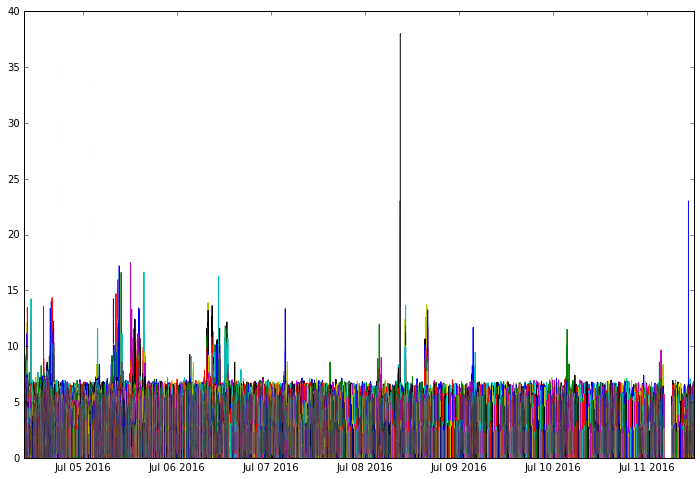

In [16]:
plt.figure(figsize=(12,8))
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
index = 0
sum_cpu_resv = []
sum_cpu_used = []
effi_cpu_resv = []
container_lst = []
duration_lst = []
app_lst = []
app_type_lst = []
user_lst = []
totalcons = len(SnapshotDFFiltered.index)
for container in SnapshotDFFiltered.index:
  cpu_used = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_resv = SnapshotDFFiltered.loc[container,"CPU"]
  duration = len(cpu_used)
  app = SnapshotDFFiltered.loc[container,"app"]
  app_type = SnapshotDFFiltered.loc[container,"type"]
  user = SnapshotDFFiltered.loc[container,"appowner"]
  total_cpu_resv =cpu_resv*duration
  #calculate sum
  total = 0
  for i in cpu_used:
    total = total + i
  if total == 0: #no info on container used
    totalcons -= 1
    #print("Container $s does not info on memory usage" % container)
    continue
  sum_cpu_used.insert(index,total)
  sum_cpu_resv.insert(index,total_cpu_resv)
  effi_cpu_resv.insert(index,float(total)/total_cpu_resv)
  duration_lst.insert(index,duration)
  container_lst.insert(index,container)
  app_lst.insert(index, app)
  app_type_lst.insert(index, app_type)
  user_lst.insert(index, user)
  index += 1
  update_progress(float(index)/totalcons)
  plt.plot(cpu_used)

In [18]:
num_cons_lst = []
avg_effi_lst = []
cdf_duration = range(1,max(duration_lst)+1)
for duration in cdf_duration:
    num_cons = 0
    total_effi = 0
    for container in range(len(container_lst)):
        if duration_lst[container] <= duration:
            total_effi += effi_cpu_resv[container]
            num_cons +=1
    if num_cons > 0:
        avg_effi = float(total_effi)/num_cons
    else:
        avg_effi = 0
    num_cons_lst.insert(duration,num_cons)
    avg_effi_lst.insert(duration,avg_effi)
cpu_num_cons_lst_shortfisrt = num_cons_lst
cpu_avg_effi_lst_shortfirst = avg_effi_lst

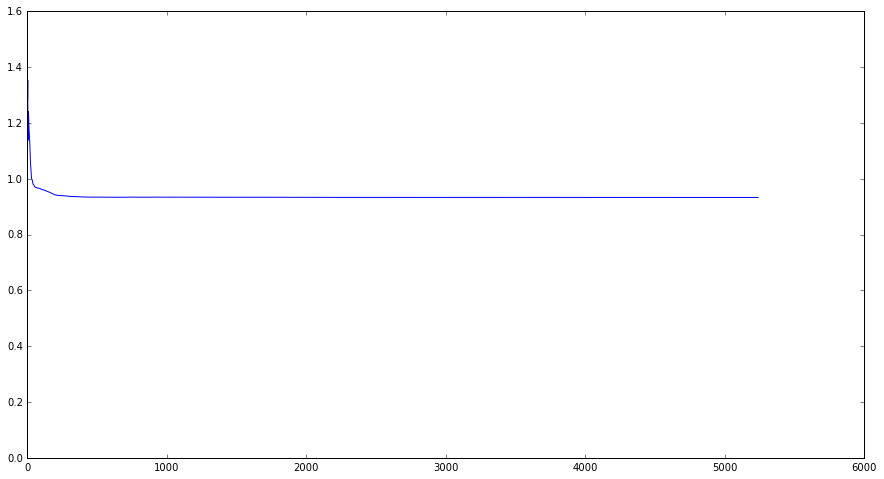

In [19]:
plt.plot(cpu_avg_effi_lst_shortfirst)
#plt.xscale('log')

In [20]:
num_cons_lst = []
avg_effi_lst = []
cdf_duration = range(1,max(duration_lst)+1)
for duration in cdf_duration:
    num_cons = 0
    total_effi = 0
    for container in range(len(container_lst)):
        if duration_lst[container] >= duration: #go backward
            total_effi += effi_cpu_resv[container]
            num_cons +=1
    if num_cons > 0:
        avg_effi = float(total_effi)/num_cons
    else:
        avg_effi = 0
    num_cons_lst.insert(duration,num_cons)
    avg_effi_lst.insert(duration,avg_effi)
cpu_num_cons_lst_longfisrt = num_cons_lst
cpu_avg_effi_lst_longfirst = avg_effi_lst

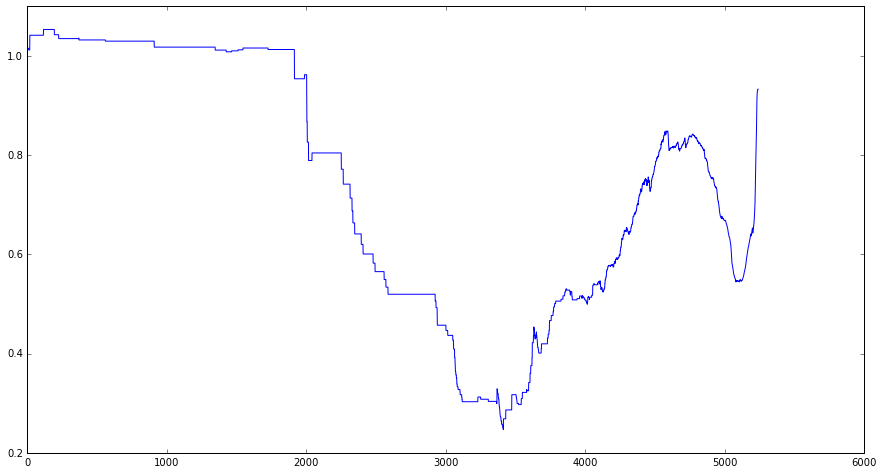

In [25]:
plt.plot(list(reversed(cpu_avg_effi_lst_longfirst)))
#plt.xscale('log')

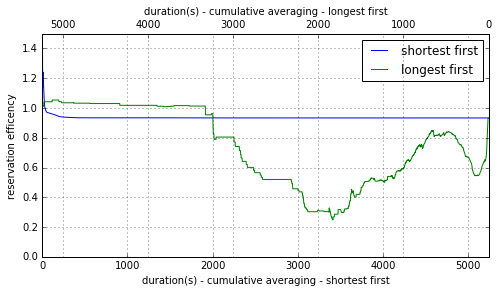

In [27]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X1 = cpu_num_cons_lst_shortfisrt
Y1 = cpu_avg_effi_lst_shortfirst
X2 = cpu_num_cons_lst_longfisrt
Y2 = cpu_avg_effi_lst_longfirst
ax1.plot(Y1)
ax1.plot(list(reversed(Y2)))
ax1.set_ylabel(r"allocation efficency")
ax1.set_xlabel(r"duration(s) - cumulative averaging - shortest first")
maxX = len(Y1)
ax1.set_xlim([0, maxX])
ax1.grid()
ax1.legend(['shortest first', 'longest first'])
new_tick_locations = np.array([ maxX - 5000, maxX - 4000, maxX - 3000, maxX - 2000, maxX - 1000, maxX])

def tick_function(X):
    maxX = max(X)
    V = maxX - X
    return ["%d" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim([0, 1.5])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"duration(s) - cumulative averaging - longest first")
ax2.grid()
plt.show()


In [28]:
num_cons_lst = []
avg_effi_lst = []
cdf_duration = range(1,max(duration_lst)+1)
for duration in cdf_duration:
    num_cons = 0
    total_used = 0
    total_resv = 0
    for container in range(len(container_lst)):
        if duration_lst[container] <= duration:
            total_used += sum_cpu_used[container]
            total_resv += sum_cpu_resv[container]
            num_cons +=1
    if num_cons > 0:
        avg_effi = float(total_used)/total_resv
    else:
        avg_effi = 0
    num_cons_lst.insert(duration,num_cons)
    avg_effi_lst.insert(duration,avg_effi)
cpu_num_cons_lst_shortfisrt_2 = num_cons_lst
cpu_avg_effi_lst_shortfirst_2 = avg_effi_lst

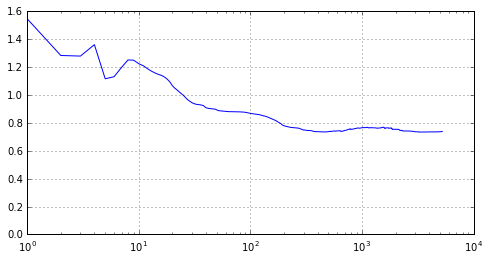

In [73]:
plt.figure(figsize=(8,4))
plt.plot(cpu_avg_effi_lst_shortfirst_2)
#plt.plot(cpu_num_cons_lst_longfisrt)
plt.xscale('log')
plt.grid()

In [30]:
num_cons_lst = []
avg_effi_lst = []
cdf_duration = range(1,max(duration_lst)+1)
for duration in list(reversed(cdf_duration)):
    num_cons = 0
    total_used = 0
    total_resv = 0
    old_num_cons = 0
    old_avg_effi = 0
    for container in range(len(container_lst)):
        if duration_lst[container] >= duration: #go backward
            total_used += sum_cpu_used[container]
            total_resv += sum_cpu_resv[container]
            num_cons +=1
    if num_cons != old_num_cons:
        avg_effi = float(total_used)/total_resv
        old_avg_effi = avg_effi
    else:
        avg_effi = old_avg_effi
    old_num_cons = num_cons
    num_cons_lst.insert(max(duration_lst)-duration,num_cons)
    avg_effi_lst.insert(max(duration_lst)-duration,avg_effi)
cpu_num_cons_lst_longfisrt_2 = num_cons_lst
cpu_avg_effi_lst_longfirst_2 = avg_effi_lst

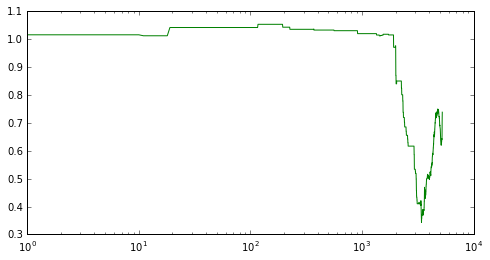

In [72]:
plt.figure(figsize=(8,4))
plt.plot(cpu_avg_effi_lst_longfirst_2, color="green")
#plt.plot(cpu_num_cons_lst_longfisrt)
plt.xscale('log')

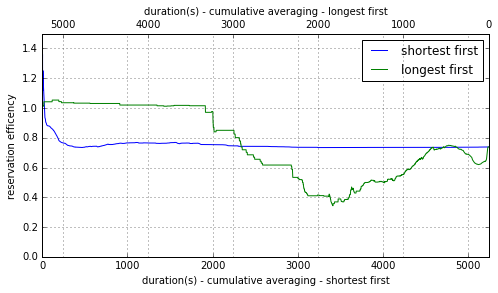

In [32]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X1 = cpu_num_cons_lst_shortfisrt_2
Y1 = cpu_avg_effi_lst_shortfirst_2
X2 = cpu_num_cons_lst_longfisrt_2
Y2 = cpu_avg_effi_lst_longfirst_2
ax1.plot(Y1)
ax1.plot(Y2)
ax1.set_ylabel(r"allocation efficency")
ax1.set_xlabel(r"duration(s) - cumulative averaging - shortest first")
maxX = len(Y1)
ax1.set_xlim([0, maxX])
ax1.grid()
ax1.legend(['shortest first', 'longest first'])
new_tick_locations = np.array([ maxX - 5000, maxX - 4000, maxX - 3000, maxX - 2000, maxX - 1000, maxX])

def tick_function(X):
    maxX = max(X)
    V = maxX - X
    return ["%d" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim([0, 1.5])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"duration(s) - cumulative averaging - longest first")
ax2.grid()
plt.show()

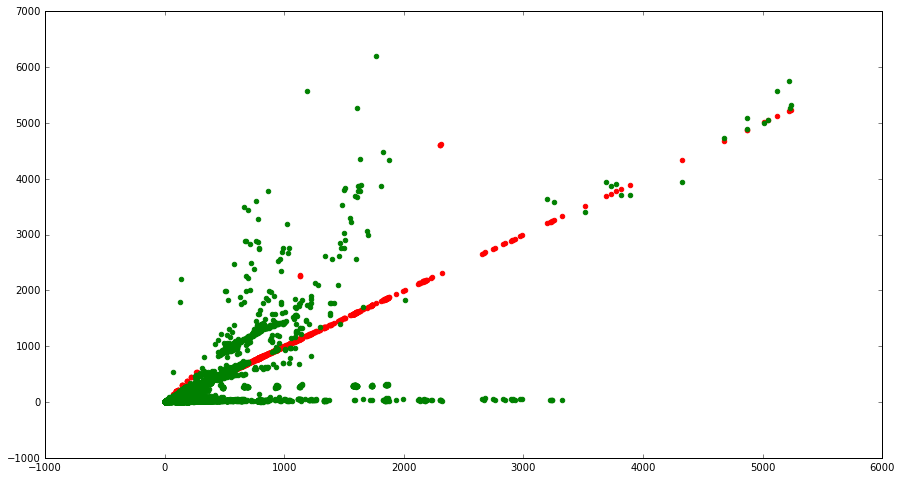

In [36]:
plt.scatter(duration_lst,sum_cpu_resv,color="red")
plt.scatter(duration_lst,sum_cpu_used,color="green")

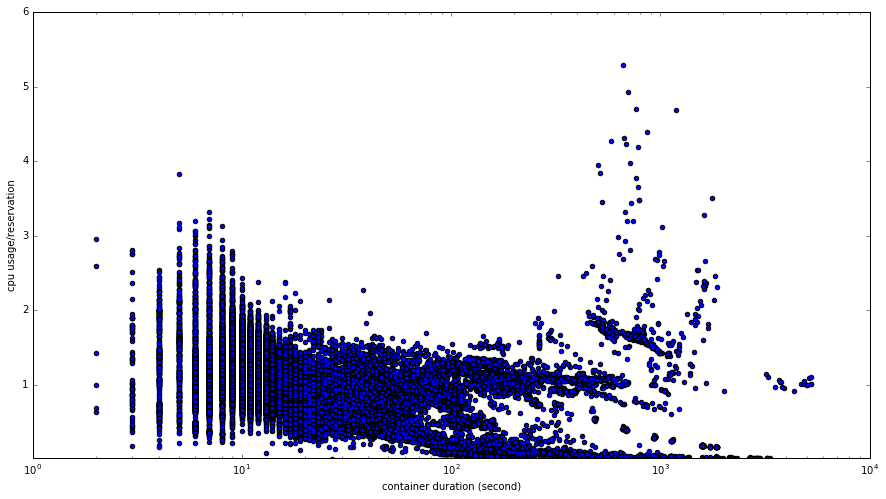

In [75]:
plt.scatter(duration_lst, effi_cpu_resv)
plt.axis([1,10000,0.01,6])
plt.xscale('log')
plt.ylabel("cpu usage/reservation")
plt.xlabel("container duration (second)")
#plt.yscale('log')

In [188]:
dataset= zip(duration_lst,effi_cpu_resv)
columns = ["duration","cpure" ]
datagram = pd.DataFrame(data = dataset, columns=columns)
datagram.sort_values("duration")
#datagram = datagram.sort_values(by)
new_datagram = datagram.groupby("duration").count()
index = list(datagram.groupby("duration").count().index)
logbin = []
logbin_index = []
bin_index = 0
bin_size = 1
for i in index:
    #arrange into bin
    if i >= 10000:
        bin_size = 10000
    elif i >= 1000:
        bin_size =1000
    elif i >= 100:
        bin_size = 100
    elif i >= 10:
        bin_size = 10
    elif i >= 1:
        bin_size = 1
    else:
        bin_size = 0
    bin_index = int(i/bin_size)*bin_size
    value = new_datagram.loc[i,'cpure']
    logbin.insert(bin_index,value)
    logbin_index.insert(bin_index, bin_index)

dataset= zip(logbin_index,logbin)
columns = ["duration","count" ]
datagram = pd.DataFrame(data = dataset, columns=columns)
datagram.sort_values("duration")
new_datagram = datagram.groupby("duration").sum()
index = list(new_datagram.index)

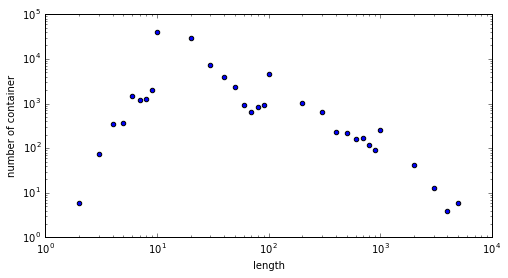

In [187]:
plt.figure(figsize=(8,4))
plt.scatter(index, new_datagram)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of container')
plt.xlabel('length')

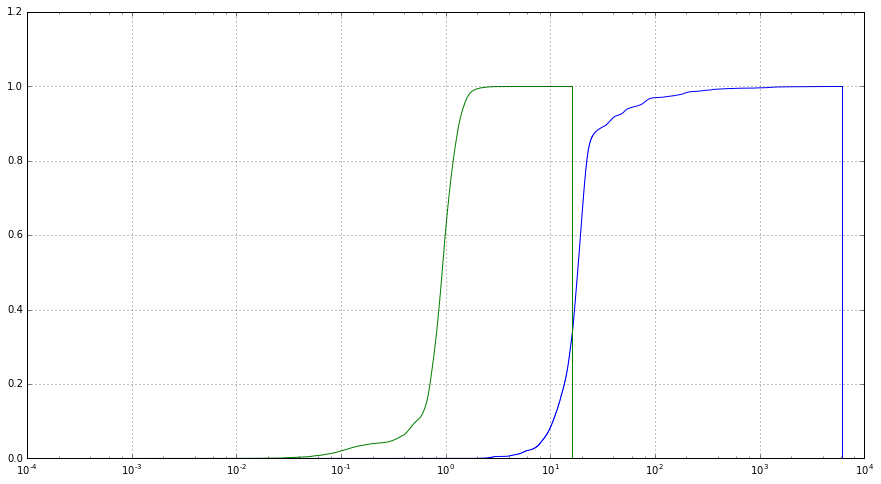

In [203]:
max_duration = max(duration_lst)
effi_weight = [ (x*y) for x, y in zip(duration_lst, effi_cpu_resv)]
plt.hist(effi_weight, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(effi_cpu_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.grid()

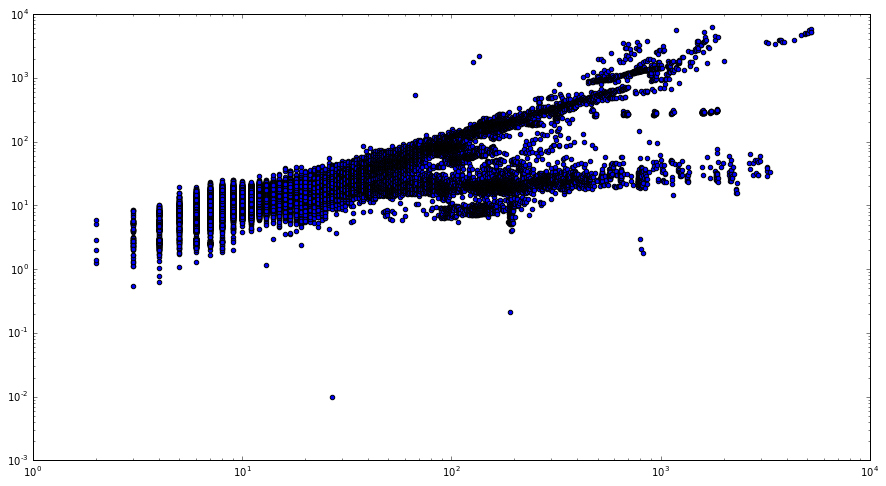

In [213]:
dataset= zip(duration_lst,effi_cpu_resv,effi_weight)
columns = ["duration","cpure",'afterweight' ]
datagram = pd.DataFrame(data = dataset, columns=columns)
datagram = datagram.sort_values("duration")
plt.scatter(datagram.duration,datagram.afterweight)
plt.yscale('log')
plt.xscale('log')

In [49]:
uniq_app_set = set(app_lst)
uniq_app = list(uniq_app_set)
total_app_used_lst = []
total_app_resv_lst = []
app_effi_lst = []
app_user_lst = []
app_index_lst = []
app_index = 0
for app in uniq_app:
    total_app_used = 0
    total_app_resv = 0
    for index in range(len(app_lst)):
        if app_lst[index] == app:
            app_used = sum_cpu_used[index]
            app_resv = sum_cpu_resv[index]
            app_user = user_lst[index]
            total_app_used += app_used
            total_app_resv += app_resv
        else:
            continue
    app_effi_lst.insert(app_index,float(total_app_used)/total_app_resv)
    total_app_used_lst.insert(app_index, total_app_used)
    total_app_resv_lst.insert(app_index, total_app_resv)
    app_user_lst.insert(app_index,app_user)
    app_index_lst.insert(app_index,app)
    app_index += 1

In [50]:
uniq_user_set = set(app_user_lst)
uniq_user=list(uniq_user_set)
total_user_used_lst = []
total_user_resv_lst = []
user_effi_lst = []
user_index = 0
for user in uniq_user:
    total_user_used = 0
    total_user_resv = 0
    for index in range(len(app_user_lst)):
        if app_user_lst[index] == user:
            user_used = total_app_used_lst[index]
            user_resv = total_app_resv_lst[index]
            total_user_used += user_used
            total_user_resv += user_resv
        else:
            continue
    user_effi_lst.insert(user_index,float(total_user_used)/total_user_resv)
    total_user_used_lst.insert(user_index, total_user_used)
    total_user_resv_lst.insert(user_index, total_user_resv)
    user_index += 1

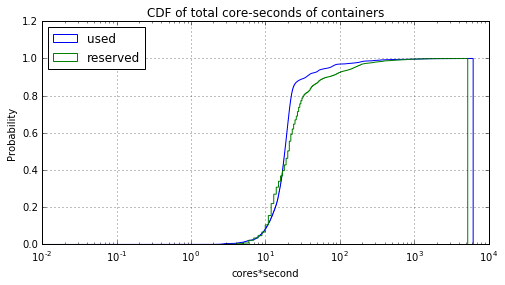

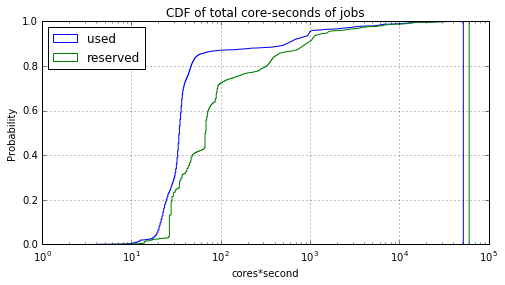

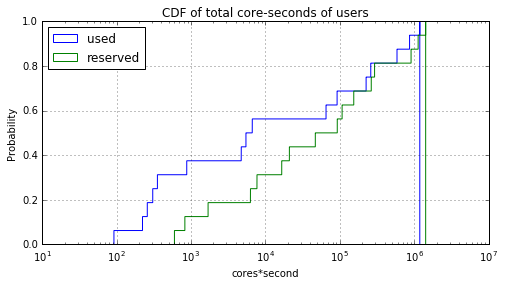

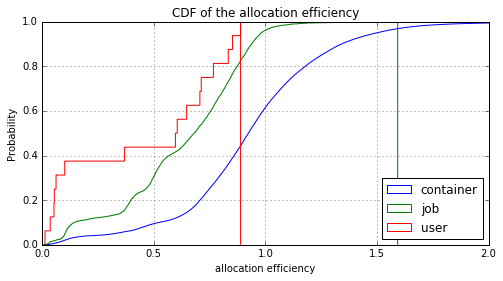

In [244]:
#How much container?
plt.figure(figsize=(8,4))
plt.hist(sum_cpu_used, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(sum_cpu_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['used', 'reserved'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('cores*second')
plt.grid()
plt.title('CDF of total core-seconds of containers')
plt.show()

#How much app?
plt.figure(figsize=(8,4))
plt.hist(total_app_used_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(total_app_resv_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['used', 'reserved'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('cores*second')
plt.grid()
plt.title('CDF of total core-seconds of jobs')
plt.show()

#How much user?
plt.figure(figsize=(8,4))
plt.hist(total_user_used_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(total_user_resv_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['used', 'reserved'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('cores*second')
plt.grid()
plt.title('CDF of total core-seconds of users')
plt.show()

#How efficient it is?
plt.figure(figsize=(8,4))
plt.hist(effi_cpu_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(app_effi_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(user_effi_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.legend(['container','job','user'],loc='lower right')
plt.ylabel('Probability')
plt.xlabel('allocation efficiency')
plt.axis([0, 2, 0, 1])
plt.grid()
plt.title('CDF of the allocation efficiency')
plt.show()


In [52]:
DataSet = list(zip(total_app_resv_lst,total_app_used_lst,app_effi_lst,app_user_lst))
columns=['total_resv','total_used','efficient','user']
AppEffiTable = pd.DataFrame(data = DataSet, index=app_index_lst,columns=columns)

UserEffiTable = AppEffiTable.groupby('user').sum()
for user in UserEffiTable.index:
    print('%s: %f' % (user, UserEffiTable.loc[user,'total_used']/UserEffiTable.loc[user,'total_resv']))

amissaoui: 0.888733
astrolog: 0.647128
dbrusley: 0.597033
falcon: 0.062022
glohier: 0.852765
gstat: 0.604981
gstathadoop: 0.833687
hdfs: 0.100915
hive: 0.706393
mhuynh: 0.035931
nlevert: 0.052857
nnefzi: 0.712614
profiling-ute: 0.767068
pvigreux: 0.012532
sducrotoy: 0.369156
spark: 0.054229


Percent: [##########] 100% Done...


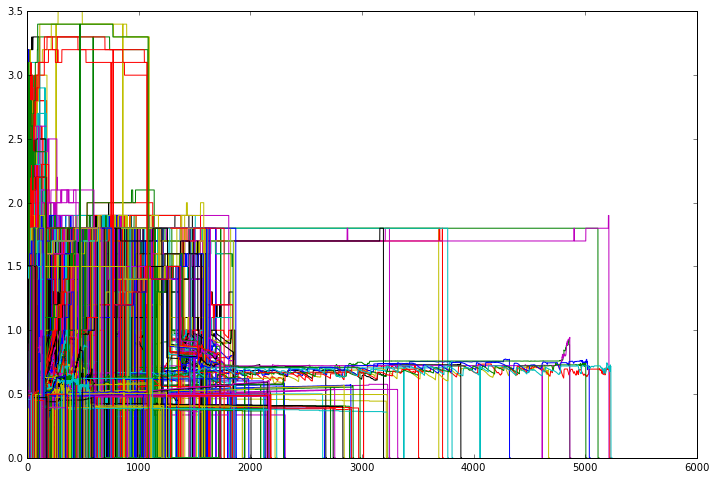

In [214]:
plt.figure(figsize=(12,8))
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
index = 0
sum_mem_resv = []
sum_mem_used = []
effi_mem_resv = []
mem_container_lst = []
mem_duration_lst = []
mem_app_lst = []
mem_app_type_lst = []
mem_user_lst = []
mem_totalcons = len(SnapshotDFFiltered.index)
for container in SnapshotDFFiltered.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ float(x) / (1024*1024*1024) for x in mem_used ]
  mem_resv = float(SnapshotDFFiltered.loc[container,"mem"])/(1024*1024)
  duration = len(mem_used)
  app = SnapshotDFFiltered.loc[container,"app"]
  app_type = SnapshotDFFiltered.loc[container,"type"]
  user = SnapshotDFFiltered.loc[container,"appowner"]
  total_mem_resv =mem_resv*duration
  #calculate sum
  total = 0
  for i in mem_used:
    total = total + i
  if total == 0: #no info on container used
    mem_totalcons -= 1
    #print("Container $s does not info on memory usage" % container)
    continue
  sum_mem_used.insert(index,total)
  sum_mem_resv.insert(index,total_mem_resv)
  effi_mem_resv.insert(index,float(total)/total_mem_resv)
  mem_duration_lst.insert(index,duration)
  mem_container_lst.insert(index,container)
  mem_app_lst.insert(index, app)
  mem_app_type_lst.insert(index, app_type)
  mem_user_lst.insert(index, user)
  index += 1
  update_progress(float(index)/mem_totalcons)
  plt.plot(mem_used)

In [215]:
uniq_app_set = set(mem_app_lst)
uniq_app = list(uniq_app_set)
mem_total_app_used_lst = []
mem_total_app_resv_lst = []
mem_app_effi_lst = []
mem_app_user_lst = []
mem_app_index_lst = []
app_index = 0
for app in uniq_app:
    total_app_used = 0
    total_app_resv = 0
    for index in range(len(mem_app_lst)):
        if mem_app_lst[index] == app:
            app_used = sum_mem_used[index]
            app_resv = sum_mem_resv[index]
            app_user = mem_user_lst[index]
            total_app_used += app_used
            total_app_resv += app_resv
        else:
            continue
    mem_app_effi_lst.insert(app_index,float(total_app_used)/total_app_resv)
    mem_total_app_used_lst.insert(app_index, total_app_used)
    mem_total_app_resv_lst.insert(app_index, total_app_resv)
    mem_app_user_lst.insert(app_index,app_user)
    mem_app_index_lst.insert(app_index,app)
    app_index += 1

In [216]:
uniq_user_set = set(mem_app_user_lst)
uniq_user=list(uniq_user_set)
mem_total_user_used_lst = []
mem_total_user_resv_lst = []
mem_user_effi_lst = []
user_index = 0
for user in uniq_user:
    total_user_used = 0
    total_user_resv = 0
    for index in range(len(mem_app_user_lst)):
        if mem_app_user_lst[index] == user:
            user_used = mem_total_app_used_lst[index]
            user_resv = mem_total_app_resv_lst[index]
            total_user_used += user_used
            total_user_resv += user_resv
        else:
            continue
    mem_user_effi_lst.insert(user_index,float(total_user_used)/total_user_resv)
    mem_total_user_used_lst.insert(user_index, total_user_used)
    mem_total_user_resv_lst.insert(user_index, total_user_resv)
    user_index += 1

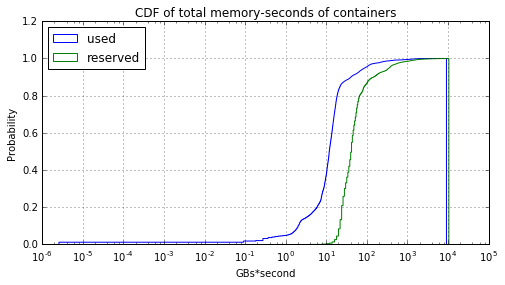

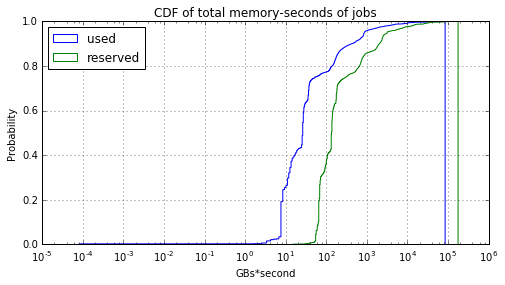

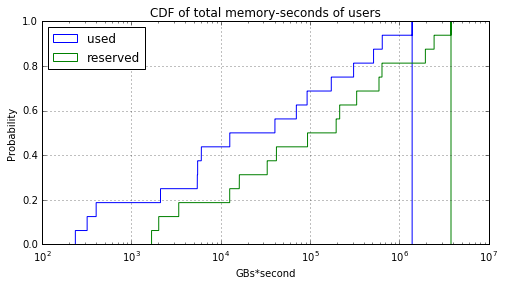

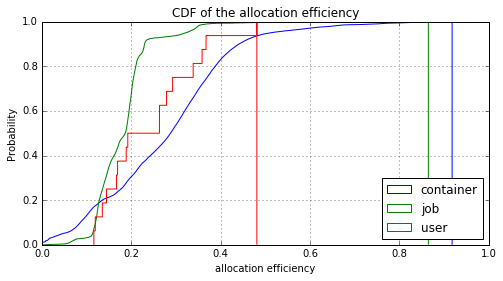

In [245]:
#How much container?
plt.figure(figsize=(8,4))
plt.hist(sum_mem_used, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(sum_mem_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['used', 'reserved'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('GBs*second')
plt.grid()
plt.title('CDF of total memory-seconds of containers')
plt.show()

#How much app?
plt.figure(figsize=(8,4))
plt.hist(mem_total_app_used_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(mem_total_app_resv_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['used', 'reserved'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('GBs*second')
plt.grid()
plt.title('CDF of total memory-seconds of jobs')
plt.show()

#How much user?
plt.figure(figsize=(8,4))
plt.hist(mem_total_user_used_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(mem_total_user_resv_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['used', 'reserved'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('GBs*second')
plt.grid()
plt.title('CDF of total memory-seconds of users')
plt.show()

#How efficient it is?
plt.figure(figsize=(8,4))
plt.hist(effi_mem_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(mem_app_effi_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.hist(mem_user_effi_lst, 100000, normed=True, cumulative=True, histtype="step")
plt.legend(['container','job','user'],loc='lower right')
plt.ylabel('Probability')
plt.xlabel('allocation efficiency')
plt.grid()
plt.title('CDF of the allocation efficiency')
plt.axis([0, 1, 0, 1])
plt.show()


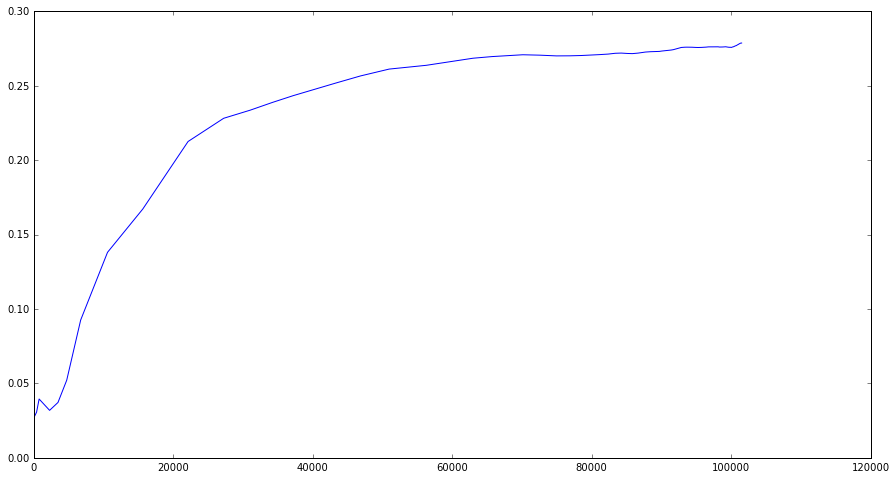

In [218]:
num_cons_lst = []
avg_effi_lst = []
cdf_duration = range(1,max(duration_lst)+1)
for duration in cdf_duration:
    num_cons = 0
    total_effi = 0
    for container in range(len(mem_container_lst)):
        if mem_duration_lst[container] <= duration:
            total_effi += effi_mem_resv[container]
            num_cons +=1
    if num_cons > 0:
        avg_effi = float(total_effi)/num_cons
    else:
        avg_effi = 0
    num_cons_lst.insert(duration,num_cons)
    avg_effi_lst.insert(duration,avg_effi)

mem_num_cons_lst_shortfisrt = num_cons_lst
mem_avg_effi_lst_shortfirst = avg_effi_lst
plt.plot(num_cons_lst,avg_effi_lst)
#plt.xscale('log')

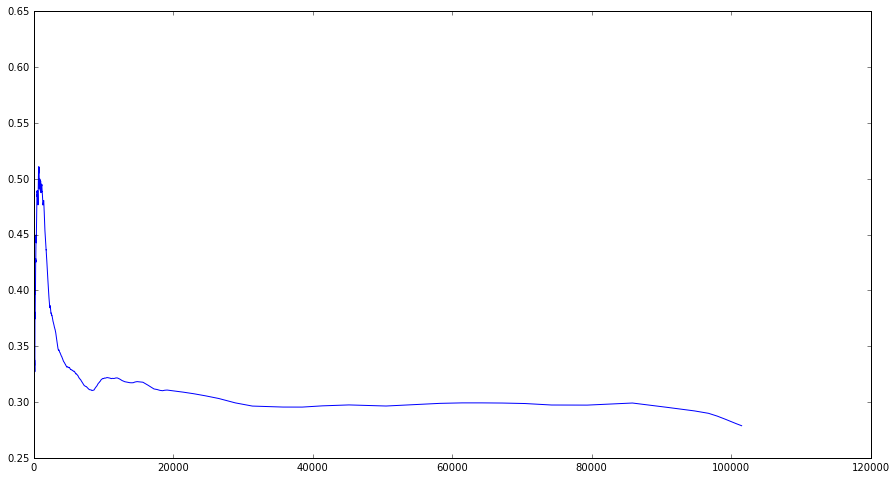

In [219]:
num_cons_lst = []
avg_effi_lst = []
cdf_duration = range(1,max(mem_duration_lst)+1)
for duration in cdf_duration:
    num_cons = 0
    total_effi = 0
    for container in range(len(mem_container_lst)):
        if mem_duration_lst[container] >= duration: #go backward
            total_effi += effi_mem_resv[container]
            num_cons +=1
    if num_cons > 0:
        avg_effi = float(total_effi)/num_cons
    else:
        avg_effi = 0
    num_cons_lst.insert(duration,num_cons)
    avg_effi_lst.insert(duration,avg_effi)

mem_num_cons_lst_longfisrt = num_cons_lst
mem_avg_effi_lst_longfirst = avg_effi_lst
plt.plot(mem_num_cons_lst_longfisrt,mem_avg_effi_lst_longfirst)
#plt.xscale('log')

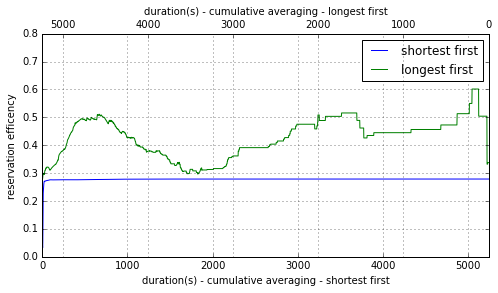

In [223]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X1 = mem_num_cons_lst_shortfisrt
Y1 = mem_avg_effi_lst_shortfirst
X2 = mem_num_cons_lst_longfisrt
Y2 = mem_avg_effi_lst_longfirst
ax1.plot(Y1)
ax1.plot(Y2)
ax1.set_ylabel(r"reservation efficency")
ax1.set_xlabel(r"duration(s) - cumulative averaging - shortest first")
maxX = len(Y1)
ax1.set_xlim([0, maxX])
ax1.grid()
ax1.legend(['shortest first', 'longest first'])
new_tick_locations = np.array([ maxX - 5000, maxX - 4000, maxX - 3000, maxX - 2000, maxX - 1000, maxX])

def tick_function(X):
    maxX = max(X)
    V = maxX - X
    return ["%d" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim([0, 0.8])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"duration(s) - cumulative averaging - longest first")
ax2.grid()
plt.show()

In [ ]:
DataSet = list(zip(mem_total_app_resv_lst,mem_total_app_used_lst,mem_app_effi_lst,mem_app_user_lst))
columns=['total_resv','total_used','efficient','user']
MemAppEffiTable = pd.DataFrame(data = DataSet, index=mem_app_index_lst,columns=columns)

MemUserEffiTable = MemAppEffiTable.groupby('user').sum()
for user in MemUserEffiTable.index:
    print('%s: %f' % (user, MemUserEffiTable.loc[user,'total_used']/MemUserEffiTable.loc[user,'total_resv']))

## Normalize Memory and CPU Usage Pattern

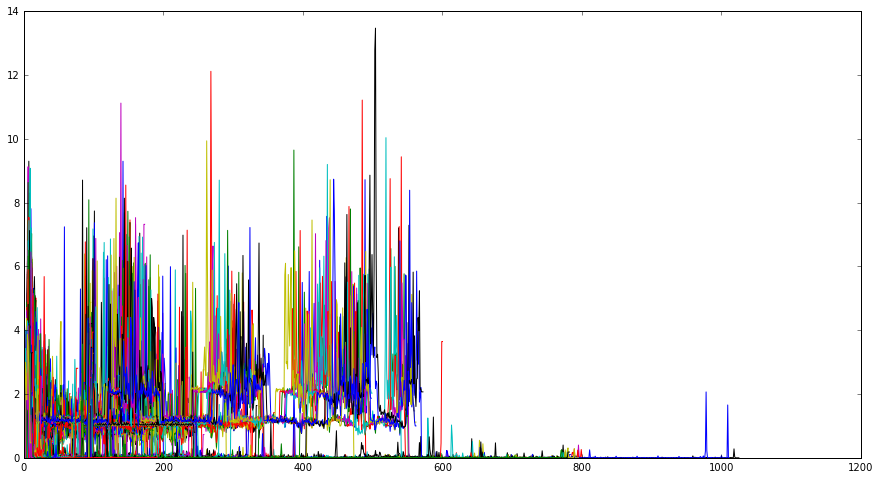

In [84]:
for container in SnapshotDFSorted.head(n=1000).index:
  cpu_usage = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_usage = [ x /snapshot_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved CPU
  plt.plot(cpu_usage)

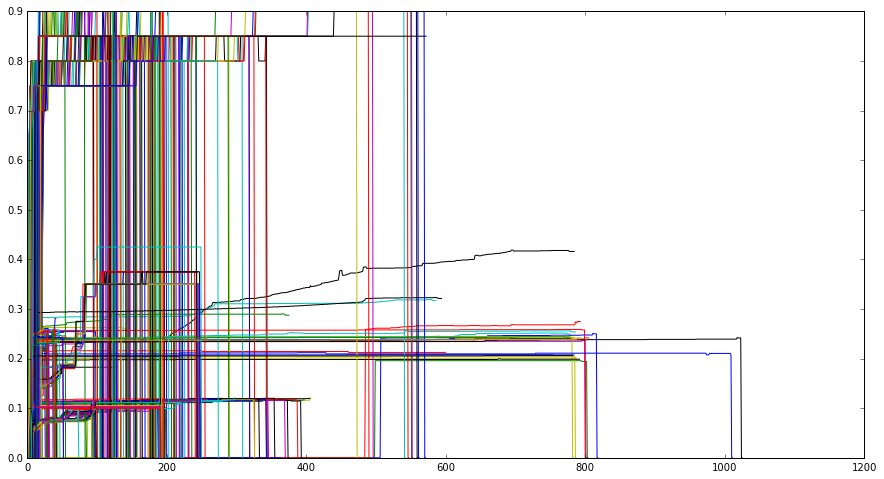

In [85]:
for container in SnapshotDFSorted.head(n=1000).index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  plt.plot(mem_used)

In [25]:
plt.figure(figsize=(12,8))

In [23]:
#Filter only MapReduce jobs, seperate container, mapper, and reducer
snapshot_dataframe_AMonly = snapshot_dataframe[snapshot_dataframe.task == "AM"]

#clean AM data because some container was recognized wrongly as AM
app_list = snapshot_dataframe_AMonly.app.unique()
AM_list = []
map_effi_mem_resv = []
i = 0
for app in app_list:
    tmp = snapshot_dataframe_AMonly[snapshot_dataframe_AMonly.app == app]
    maxduration = 0
    for container in tmp.index:
        duration = tmp.loc[container,"end"] - tmp.loc[container,"start"]
        if duration > maxduration:
            maxduration = duration
            AM = container
    AM_list.insert(i,AM)
    i += 1
print(len(AM_list))

7668


In [26]:
for container in AM_list:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  plt.plot(mem_used)

In [ ]:
for container in AM_list:
  cpu_usage = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_usage = [ x /snapshot_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved CPU
  plt.plot(cpu_usage)

In [32]:
index = 0
am_effi_mem_resv = []
totalcons = len(AM_list)
for container in AM_list:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  duration = len(mem_used)
  #calculate sum
  total = 0
  for i in mem_used:
    total = total + i
  am_effi_mem_resv.insert(index,float(total)/(duration))
  index += 1
  update_progress(float(index)/totalcons)
  plt.plot(mem_used)

Percent: [##########] 100% Done...


<IPython.core.display.Javascript object>


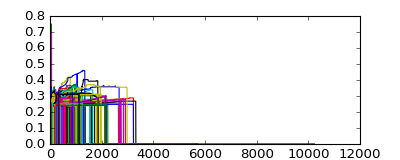

<IPython.core.display.Javascript object>


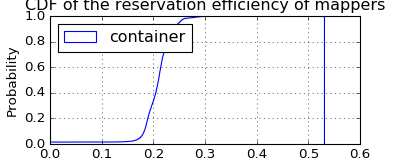

In [33]:
#How efficient it is?
plt.figure(figsize=(5,2))
plt.hist(am_effi_mem_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.legend(['container', 'job'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('reservation efficiency')
plt.grid()
plt.title('CDF of the reservation efficiency of mappers')
plt.show()

7668
Percent: [##########] 100% Done...


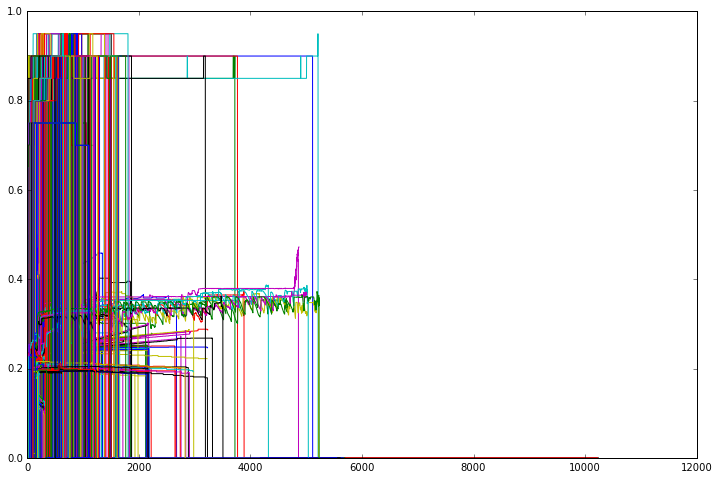

In [88]:
snapshot_dataframe_MAPonly = snapshot_dataframe[snapshot_dataframe.task == "MAP"]
index = 0
map_effi_mem_resv = []
totalcons = len(snapshot_dataframe_MAPonly.index)
for container in snapshot_dataframe_MAPonly.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  duration = len(mem_used)
  #calculate sum
  total = 0
  for i in mem_used:
    total = total + i
  map_effi_mem_resv.insert(index,float(total)/(duration))
  index += 1
  update_progress(float(index)/totalcons)
  plt.plot(mem_used)

<IPython.core.display.Javascript object>


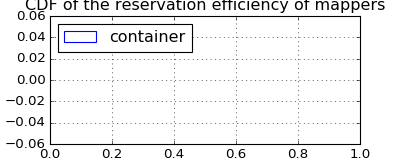

In [30]:
#How efficient it is?
plt.figure(figsize=(5,2))
plt.hist(map_effi_mem_resv, 100000, normed=True, cumulative=True, histtype="step")
plt.legend(['container', 'job'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('reservation efficiency')
plt.grid()
plt.title('CDF of the reservation efficiency of mappers')
plt.show()

In [ ]:
for container in snapshot_dataframe_MAPonly.index:
  cpu_usage = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_usage = [ x /snapshot_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved CPU
  plt.plot(cpu_usage)

In [ ]:
plt.figure(figsize=(12,8))
snapshot_dataframe_REDUCEonly = snapshot_dataframe[snapshot_dataframe.task == "REDUCE"]
index = 0
effe_mem_resv = []
totalcons = len(snapshot_dataframe_REDUCEonly.index)
for container in snapshot_dataframe_REDUCEonly.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  duration = len(mem_used)
  #calculate sum
  total = 0
  for i in mem_used:
    total = total + i
  effe_mem_resv.insert(index,float(total)/(duration))
  index += 1
  update_progress(float(index)/totalcons)
  plt.plot(mem_used)

In [ ]:
#How efficient it is?
plt.figure(figsize=(5,2))
plt.hist(effe_mem_resv, 100000, normed=True, cumulative=True, histtype="step")
#plt.legend(['effe'],loc='upper right')
plt.ylabel('Probability')
plt.xlabel('reservation efficiency')
plt.grid()
plt.title('CDF of the reservation efficiency of reducers')
plt.show()

In [ ]:
for container in snapshot_dataframe_REDUCEonly.index:
  cpu_usage = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_usage = [ x /snapshot_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved CPU
  plt.plot(cpu_usage)

In [ ]:
%matplotlib inline
SnapshotDFFiltered = SnapshotDFSorted

# Filter to select data in a specific time period
#startperiod = 1467367720000
#endperiod =   1467375440000
#tmpdf = SnapshotDFFiltered[(SnapshotDFFiltered.start <= startperiod)] 
#tmpdf = tmpdf[(tmpdf.end >= startperiod)]
#if tmpdf.empty:
#  new_start = startperiod #no container running across this point
#else:
#  new_start = tmpdf.start.min()
#tmpdf = SnapshotDFFiltered[(SnapshotDFFiltered.start <= endperiod)]
#tmpdf = tmpdf[(tmpdf.end >= endperiod)]
#if tmpdf.empty:
#  new_end = endperiod #no container running across this point
#else:
#  new_end = tmpdf.end.max()
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.start >= new_start)]
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.end <= new_end)]

# Filter to remove containers with no informaction of the node, or to select specific nodes
# SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]

# Filter to select specific nodes
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.node != 'svr05.spo:45454')]

# Filter to select specific apps
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.app == 'application_1466697692331_3253')]

# Filter to select specific user
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.appowner == 'astrolog')]

# get list of applications
application_list = SnapshotDFFiltered.app.unique().tolist()
# limit number of app to draw
#head=0
#tail=200
#application_list = application_list[head:tail]
#cumtmpdf = pd.DataFrame()
#for app in application_list:
#  tmpdf = SnapshotDFFiltered[(SnapshotDFFiltered.app == app)]
#  cumtmpdf = cumtmpdf.append(tmpdf)
#SnapshotDFFiltered = cumtmpdf
                             
# get list of users
user_list = SnapshotDFFiltered.appowner.unique().tolist()
print("There are %d users in the trace" % len(user_list))

'''FOR CPU'''
SnapshotDFFiltered_group_node = SnapshotDFFiltered.groupby("node")
total_phy_CPU = SnapshotDFFiltered_group_node.n_CPU.mean().sum() #assume capacity has no change
total_rsrv_CPU = SnapshotDFFiltered_group_node.CPU_rsrv.mean().sum() #assume capacity has no change
print('Total physical cores in these nodes: %s cores' % total_phy_CPU)
print('Total virtual cores reserved for YARN in these nodes: %s cores' % total_rsrv_CPU)

# create vector zero
snapshot_starttime = SnapshotDFFiltered.start.min()    # overwrite the starting point after filter
snapshot_endtime =  SnapshotDFFiltered.end.max()     # overwrite the end point after filter
rescaled_snapshot_starttime = snapshot_starttime / 1000
rescaled_snapshot_endtime = snapshot_endtime / 1000
rescaled_snapshot_duration = rescaled_snapshot_endtime - rescaled_snapshot_starttime
time = np.linspace(rescaled_snapshot_starttime, rescaled_snapshot_endtime-1,rescaled_snapshot_duration)
zero_vector = pd.Series(np.linspace(0, 0,rescaled_snapshot_duration), index=time)
base_vector_cpu_resv = zero_vector
base_vector_cpu_actl = zero_vector
base_vector_mem_resv = zero_vector
base_vector_mem_actl = zero_vector
print(snapshot_starttime)
print(snapshot_endtime)

phy_CPU = np.linspace(total_phy_CPU,total_phy_CPU,rescaled_snapshot_duration)
rsrv_CPU = np.linspace(total_rsrv_CPU,total_rsrv_CPU,rescaled_snapshot_duration)
phy_CPU = pd.Series(phy_CPU,index=time)
rsrv_CPU = pd.Series(rsrv_CPU,index=time)

'''FOR MEMORY'''
total_phy_mem = SnapshotDFFiltered_group_node.n_mem.mean().sum() #assume capacity has no change
total_rsrv_mem = SnapshotDFFiltered_group_node.mem_rsrv.mean().sum() #assume capacity has no change
# convert from KB to GB
total_phy_mem = float(total_phy_mem) / (1024*1024)
total_rsrv_mem = float(total_rsrv_mem) / (1024*1024)
print('Total physical memory in these nodes: %s GBs' % total_phy_mem)
print('Total memory reserved for YARN in these nodes: %s GBs' % total_rsrv_mem)

phy_mem = np.linspace(total_phy_mem,total_phy_mem,rescaled_snapshot_duration)
rsrv_mem = np.linspace(total_rsrv_mem,total_rsrv_mem,rescaled_snapshot_duration)
phy_mem = pd.Series(phy_mem,index=time)
rsrv_mem = pd.Series(rsrv_mem,index=time)

i = 0
user_resv_cpu = []
user_actl_cpu = []
user_resv_mem = []
user_actl_mem = []
user_index = 0
for user in user_list:
  user_cr_data = zero_vector
  user_ca_data = zero_vector
  user_mr_data = zero_vector
  user_ma_data = zero_vector
  for application in application_list:
    i = i + 1
    update_progress(float(i)/(len(application_list)*len(user_list)))
    for index in SnapshotDFFiltered.index:
      if SnapshotDFFiltered.loc[index,'app'] == application and SnapshotDFFiltered.loc[index,'appowner'] == user:
        # get CPU allocated for that container
        container_starttime = SnapshotDFFiltered.loc[index,'start']
        container_endtime = SnapshotDFFiltered.loc[index,'end']
        rescaled_container_starttime = int(container_starttime) / 1000
        rescaled_container_endtime = int(container_endtime) / 1000
        container_duration = rescaled_container_endtime - rescaled_container_starttime
        ###### CPU Reservation
        container_cpu_value = np.linspace(SnapshotDFFiltered.loc[index,'CPU'],
                                    SnapshotDFFiltered.loc[index,'CPU'],
                                    container_duration)
        container_time_index = np.linspace(rescaled_container_starttime,
                                           rescaled_container_endtime-1,
                                           container_duration)
        container_cpu_resv_data = pd.Series(container_cpu_value, index=container_time_index)
        # checking if all points in container data belongs to the snapshot timeframe
        check = set(container_time_index) - set(time)
        if len(check): #not empty
          raise Exception("Error, data point's mismatch")
        ###### actual CPU used '''
        actual_cpu_use = get_cpu_actual_use(index,snapshot_dataframe, snapshot_cpu_profile)
        actual_cpu_use = actual_cpu_use.tolist()
        '''because the return may have lengh longer, we generate the container_time_index again'''
        container_cpu_time_index = np.linspace(rescaled_container_starttime,
                                               rescaled_container_starttime+(len(actual_cpu_use)-1),
                                               len(actual_cpu_use))
        container_cpu_actl_data = pd.Series(actual_cpu_use, index=container_cpu_time_index)
        # checking if all points in container data belongs to the snapshot timeframe
        check = set(container_cpu_time_index) - set(time)
        if len(check): #not empty
          raise Exception("Error, data point's mismatch")
        ####### memory reservation
        mem = float(SnapshotDFFiltered.loc[index,'mem']) / (1024*1024)
        container_mem_value = np.linspace(mem,mem,container_duration)
        container_mem_resv_data = pd.Series(container_mem_value, index=container_time_index)
        ####### actual memory
        actual_mem_use = get_mem_actual_use(index,snapshot_dataframe, snapshot_mem_profile)
        actual_mem_use = actual_mem_use.tolist()
        actual_mem_use = [x / (1024*1024*1024) for x in actual_mem_use]
        '''because the return may have lengh longer, we generate the container_time_index again'''
        container_mem_time_index = np.linspace(rescaled_container_starttime,
                                         rescaled_container_starttime+len(actual_mem_use)-1,
                                         len(actual_mem_use))
        container_mem_actl_data = pd.Series(actual_mem_use, index=container_mem_time_index)
        # checking if all points in container data belongs to the snapshot timeframe
        check = set(container_mem_time_index) - set(time)
        if len(check): #not empty
          raise Exception("Error, data point's mismatch")        
        # matching the container data with the length of the snapshot
        container_cpu_resv_data = container_cpu_resv_data + zero_vector
        container_cpu_resv_data = container_cpu_resv_data.fillna(0)
        container_cpu_actl_data = container_cpu_actl_data + zero_vector
        container_cpu_actl_data = container_cpu_actl_data.fillna(0)
        container_mem_resv_data = container_mem_resv_data + zero_vector
        container_mem_resv_data = container_mem_resv_data.fillna(0)
        container_mem_actl_data = container_mem_actl_data + zero_vector
        container_mem_actl_data = container_mem_actl_data.fillna(0)
        # create drawing vector based on base_vector
        user_cpu_resv_data = container_cpu_resv_data #for stackplot
        user_cpu_actl_data = container_cpu_actl_data #for stackplot
        user_mem_resv_data = container_mem_resv_data #for stackplot
        user_mem_actl_data = container_mem_actl_data #for stackplot
        container_cpu_resv_data = container_cpu_resv_data + base_vector_cpu_resv #add up new data
        base_vector_cpu_resv = container_cpu_resv_data # update base_vector for next iteration
        container_cpu_actl_data = container_cpu_actl_data + base_vector_cpu_actl #add up new data
        base_vector_cpu_actl = container_cpu_actl_data # update base_vector for next iteration
        container_mem_resv_data = container_mem_resv_data + base_vector_mem_resv #add up new data
        base_vector_mem_resv = container_mem_resv_data # update base_vector for next iteration
        container_mem_actl_data = container_mem_actl_data + base_vector_mem_actl #add up new data
        base_vector_mem_actl = container_mem_actl_data # update base_vector for next iteration
        # for stackplot
        user_cpu_resv_data = user_cpu_resv_data + user_cr_data
        user_cr_data = user_cpu_resv_data
        user_cpu_actl_data = user_cpu_actl_data + user_ca_data
        user_ca_data = user_cpu_actl_data
        user_mem_resv_data = user_mem_resv_data + user_mr_data
        user_mr_data = user_mem_resv_data
        user_mem_actl_data = user_mem_actl_data + user_ma_data
        user_ma_data = user_mem_actl_data
  user_resv_cpu.insert(user_index,user_cr_data)
  user_actl_cpu.insert(user_index,user_ca_data)
  user_resv_mem.insert(user_index,user_mr_data)
  user_actl_mem.insert(user_index,user_ma_data)
  user_index += 1
resv_cpu = base_vector_cpu_resv
actl_cpu = base_vector_cpu_actl
resv_mem = base_vector_mem_resv
actl_mem = base_vector_mem_actl

### Distribution of app duration

In [66]:
duration_data_jobs = []
index = 0
for AMcontainer in AM_list:
    AMcontainer_duration = snapshot_dataframe.loc[AMcontainer,'end'] - snapshot_dataframe.loc[AMcontainer,'start']
    AMcontainer_duration = int(AMcontainer_duration)/1000
    duration_data_jobs.insert(index, AMcontainer_duration)
    index += 1

NameError: name 'AM_list' is not defined

<IPython.core.display.Javascript object>


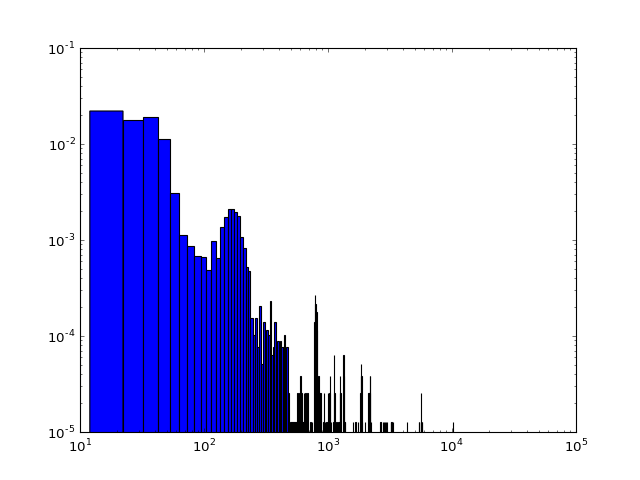

In [52]:
myHist = plt.hist(duration_data_jobs, 1000, normed="false")
plt.yscale('log')
plt.xscale('log')
plt.show()

<IPython.core.display.Javascript object>


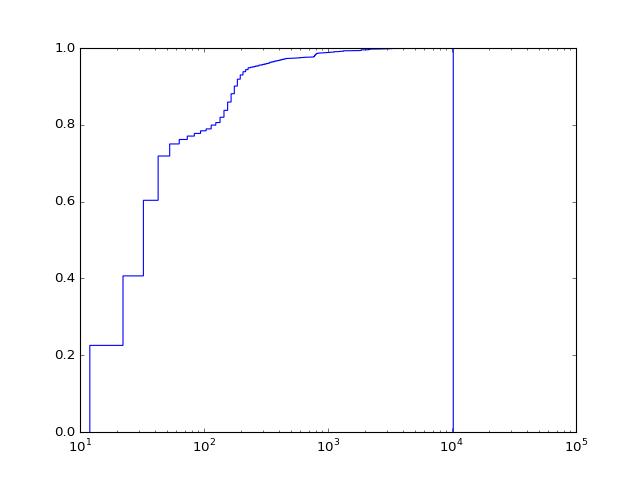

In [53]:
#CDF    
myHist1 = plt.hist(duration_data_jobs, 1000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.show()

### Distrubution of containers duration

In [64]:
duration_data_cons = []
index = 0
for container in snapshot_dataframe.index:
    container_duration = snapshot_dataframe.loc[container,'end'] - snapshot_dataframe.loc[container,'start']
    container_duration = int(container_duration)/1000
    duration_data_cons.insert(index, container_duration)
    index += 1

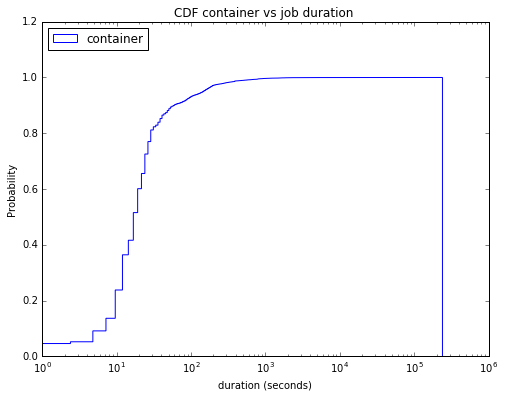

In [70]:
plt.figure(figsize=(8,6))
plt.hist(duration_data_cons, 100000, normed=True, cumulative=True, histtype="step")
#plt.hist(duration_data_jobs, 100000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.legend(['container', 'job'],loc='upper left')
plt.ylabel('Probability')
plt.xlabel('duration (seconds)')
plt.title('CDF container vs job duration ')
plt.show()

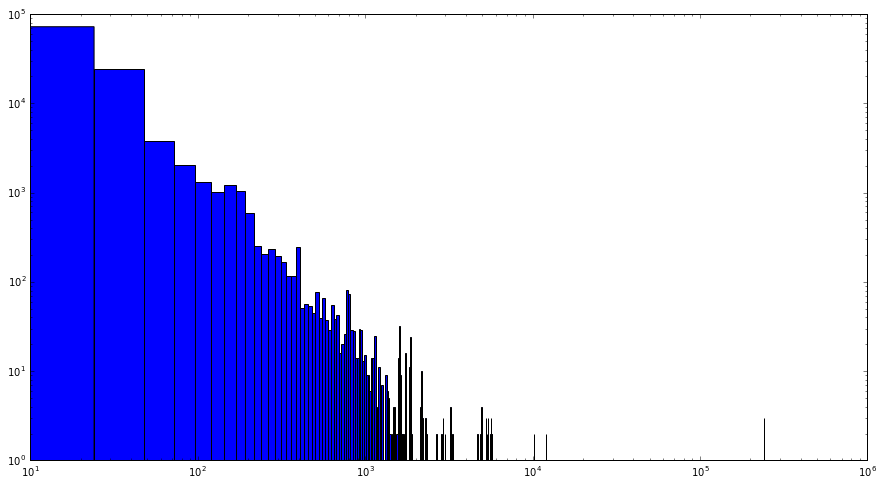

In [69]:
myHist2 = plt.hist(duration_data_cons, 10000)
plt.yscale('log')
plt.xscale('log')
plt.show()

### Applications arrival rate

In [ ]:
# divided time into block of 10mins, then calculate the number of application masters arrive during the duration


### Container arrival rate

In [ ]:
duration=60 #second


### Distribution of Mapper spilling phase

### Distribution of Reducer shuffle time

### Jobs delay

In [232]:
def load_AM(folder):
    """Load the container data for each application."""
    container_index = 0
    container_name_list = []
    container_starttime_list = []
    container_endtime_list = []
    container_task_list = []
    app_id_list = []
    app_submittedtime_list = []
    app_startedtime_list = []
    app_finishedtime_list = []
    app_state_list = []
    app_owner_list = []
    app_name_list = []
    app_queue_list = []
    app_type_list = []
    for container in os.listdir(folder):
        container_file = os.path.join(folder, container)
        try:
            with open(container_file) as data_file:    
                data = json.load(data_file)
                container_name = data["container_id"]
                container_starttime = data["container_starttime"]
                container_endtime = data["container_endtime"]
                """gather info for container"""
                app_id = data["application_info"]["appId"]
                app_submittedtime = data["application_info"]["submittedTime"]
                app_startedtime = data["application_info"]["startedTime"]
                app_finishedtime = data["application_info"]["finishedTime"]
                app_state = data["application_info"]["finalAppStatus"]
                app_owner = data["application_info"]["appOwner"]
                app_name = data["application_info"]["appName"]
                app_queue = data["application_info"]["queue"]
                app_type = data["application_info"]["appType"]
                if not data["container_tasks"]:
                    continue
                elif app_finishedtime == 0:
                    continue
                elif container_endtime == 0:
                    continue
                elif container_starttime == 0:
                    continue
                elif data["container_tasks"][0]["task_type"] != "AM": # select AM only
                    continue
                else:
                    container_task = data["container_tasks"][0]["task_type"]
                    """make list to create dataframe"""
                    container_name_list.insert(container_index,container_name)
                    container_starttime_list.insert(container_index,container_starttime)
                    container_endtime_list.insert(container_index,container_endtime)
                    container_task_list.insert(container_index,container_task)
                    app_id_list.insert(container_index,app_id)
                    app_submittedtime_list.insert(container_index,app_submittedtime)
                    app_startedtime_list.insert(container_index,app_startedtime)
                    app_finishedtime_list.insert(container_index,app_finishedtime)
                    app_state_list.insert(container_index, app_state)
                    app_owner_list.insert(container_index,app_owner)
                    app_name_list.insert(container_index,app_name)
                    app_queue_list.insert(container_index,app_queue)
                    app_type_list.insert(container_index,app_type)
                    container_index += 1
            if not container_name:
                raise Exception('Unexpected container name')      
        except IOError as e:
            print('Could not read:', container_file, ':', e)
        except ValueError as e:
            print('Wrong format. Could not read:', container_file, ':', e)
    DataSet = list(zip(container_starttime_list, container_endtime_list, container_task_list, 
                       app_id_list, app_submittedtime_list, app_startedtime_list, app_finishedtime_list,
                       app_state_list, app_owner_list, app_name_list, app_queue_list, app_type_list))
    columns=[ 'start', 'end', 'task','app_id', 'app_submit', 'app_start', 'app_end', 'app_state', 'app_owner',
              'app_name', 'app_queue', 'type']
    DataFrame = pd.DataFrame(data = DataSet, index=container_name_list,
                           columns=columns)
    return DataFrame


def load_allAM(snapshot_folders):
    snapshot_dataframe = pd.DataFrame()
    for application_folder in snapshot_folders: 
        dataframe = load_AM(application_folder)
        if snapshot_dataframe.empty:
            snapshot_dataframe = dataframe
        else:
            snapshot_dataframe = snapshot_dataframe.append(dataframe)
    return snapshot_dataframe

Application_TimeTable = load_allAM(clustersnapshot_folders)
Application_TimeTable.head(n=5)

Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_10877_json\container_e88_1467203595416_10877_01_000006.jsonprofile : Expecting , delimiter: line 1 column 20970 (char 20969)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11083_json\container_e88_1467203595416_11083_01_000001.jsonprofile : Expecting , delimiter: line 1 column 20596 (char 20595)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_11619_json\container_e88_1467203595416_11619_01_000001.jsonprofile : Expecting , delimiter: line 1 column 76650 (char 76649)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_12320_json\container_e88_1467203595416_12320_01_000002.jsonprofile : Expecting , delimiter: line 1 column 694036 (char 694035)
Wrong format. Could not read: OrangeOneWeekLogs\application_1467203595416_5877_json\container_e88_1467203595416_5877_01_000004.jsonprofile : Expecting , delimiter: line 1 column 32862 (char 32861)
Wrong

start           end task  \
container_e88_1467203595416_10000_01_000001  1.467809e+12  1.467809e+12   AM   
container_e88_1467203595416_10001_01_000001  1.467809e+12  1.467809e+12   AM   
container_e88_1467203595416_10002_01_000001  1.467809e+12  1.467809e+12   AM   
container_e88_1467203595416_10003_01_000001  1.467809e+12  1.467809e+12   AM   
container_e88_1467203595416_10004_01_000001  1.467809e+12  1.467809e+12   AM   

                                                                      app_id  \
container_e88_1467203595416_10000_01_000001  application_1467203595416_10000   
container_e88_1467203595416_10001_01_000001  application_1467203595416_10001   
container_e88_1467203595416_10002_01_000001  application_1467203595416_10002   
container_e88_1467203595416_10003_01_000001  application_1467203595416_10003   
container_e88_1467203595416_10004_01_000001  application_1467203595416_10004   

                                               app_submit     app_start  \
container_e88_1467203595416_10000_01_000001  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10001_01_000001  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10002_01_000001  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10003_01_000001  1.467809e+12  1.467809e+12   
container_e88_1467203595416_10004_01_000001  1.467809e+12  1.467809e+12   

                                                  app_end  app_state  \
container_e88_1467203595416_10000_01_000001  1.467809e+12  SUCCEEDED   
container_e88_1467203595416_10001_01_000001  1.467809e+12  SUCCEEDED   
container_e88_1467203595416_10002_01_000001  1.467809e+12  SUCCEEDED   
container_e88_1467203595416_10003_01_000001  1.467809e+12  SUCCEEDED   
container_e88_1467203595416_10004_01_000001  1.467809e+12  SUCCEEDED   

                                               app_owner  \
container_e88_1467203595416_10000_01_000001  gstathadoop   
container_e88_1467203595416_10001_01_000001  gstathadoop   
container_e88_1467203595416_10002_01_000001  gstathadoop   
container_e88_1467203595416_10003_01_000001  gstathadoop   
container_e88_1467203595416_10004_01_000001  gstathadoop   

                                                                                      app_name  \
container_e88_1467203595416_10000_01_000001  oozie:launcher:T=sqoop:W=Gstat_w1_import_conf_...   
container_e88_1467203595416_10001_01_000001  oozie:action:T=sqoop:W=Gstat_w1_import_conf_ax...   
container_e88_1467203595416_10002_01_000001  oozie:launcher:T=sqoop:W=Gstat_w1_import_conf_...   
container_e88_1467203595416_10003_01_000001  oozie:action:T=sqoop:W=Gstat_w1_import_conf_ax...   
container_e88_1467203595416_10004_01_000001  oozie:action:T=sqoop:W=Gstat_w1_import_conf_ax...   

                                                  app_queue       type  
container_e88_1467203595416_10000_01_000001  oozie-launcher  MAPREDUCE  
container_e88_1467203595416_10001_01_000001        analyses  MAPREDUCE  
container_e88_1467203595416_10002_01_000001  oozie-launcher  MAPREDUCE  
container_e88_1467203595416_10003_01_000001        analyses  MAPREDUCE  
container_e88_1467203595416_10004_01_000001        analyses  MAPREDUCE

In [237]:
print('Distribution on job:')
a, b, c, d = Application_TimeTable.app_id.describe()
print("total containers: %d" % a)
print("total jobs: %d" % b)
print("job has the most containers is %s with %d containers" % (c,d))

#Display app that has the most number of AM
App = Application_TimeTable[Application_TimeTable.app_id == c]

#clean AM data because some container was recognized wrongly as AM
app_list = Application_TimeTable.app_id.unique()
AM_list = []
i = 0
for app in app_list:
    tmp = Application_TimeTable[Application_TimeTable.app_id == app] #filter one app
    maxduration = 0
    soonest = 100000000000000
    for container in tmp.index:
        duration = tmp.loc[container,"end"] - tmp.loc[container,"start"]
        start = tmp.loc[container,"start"]
        if duration > maxduration:
            maxduration = duration
            AM1 = container
        if start < soonest:
            soonest = start
            AM2 = container
    if AM1 == AM2:
        AM_list.insert(i,AM1)
    else:
        print("The soonest one is not the longest one for app %s" % app )
    i += 1
print("After refining the list we have %d AMs for %d jobs" % (len(AM_list), b))

Distribution on job:
total containers: 11462
total jobs: 7668
job has the most containers is application_1467985353625_1806 with 460 containers
The soonest one is not the longest one for app application_1467203595416_5924
The soonest one is not the longest one for app application_1467203595416_6758
The soonest one is not the longest one for app application_1467203595416_6761
After refining the list we have 7665 AMs for 7668 jobs


In [243]:
Application_TimeTable.to_csv('Apps.csv')

In [238]:
#Plotting
duration_waiting_1stcontainer = []
duration_waiting_aftersubmit = []
index = 0
for AM in AM_list:
    dwfc = Application_TimeTable.loc[AM,"start"] - Application_TimeTable.loc[AM,"app_submit"]
    dwas = Application_TimeTable.loc[AM,"app_start"] - Application_TimeTable.loc[AM,"app_submit"]
    duration_waiting_1stcontainer.insert(index,int(dwfc)/1000)
    duration_waiting_aftersubmit.insert(index,int(dwas)/1000)
    index += 1

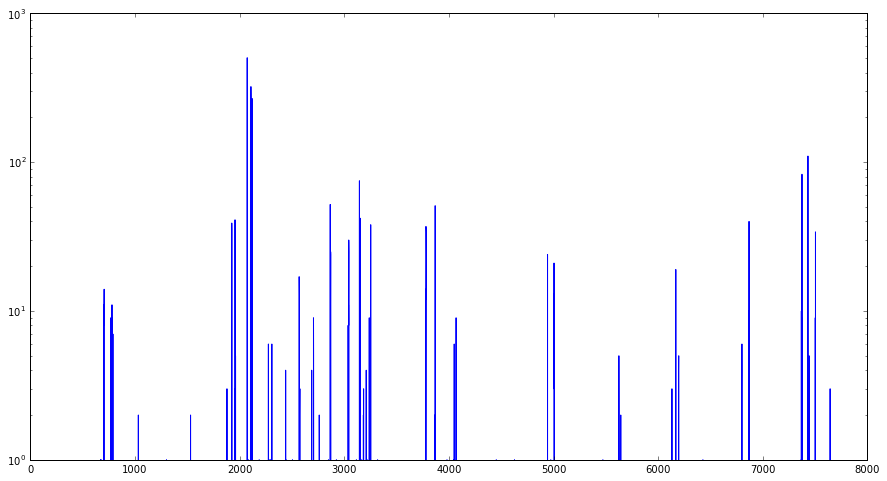

In [239]:
plt.plot(duration_waiting_1stcontainer, 'b')
plt.yscale('log')
plt.show()

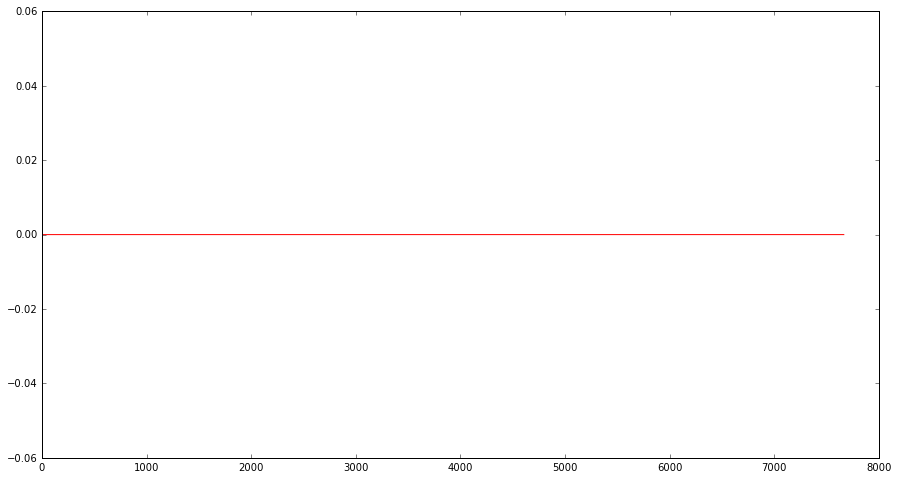

In [240]:
plt.plot(duration_waiting_aftersubmit, 'r')
plt.show()

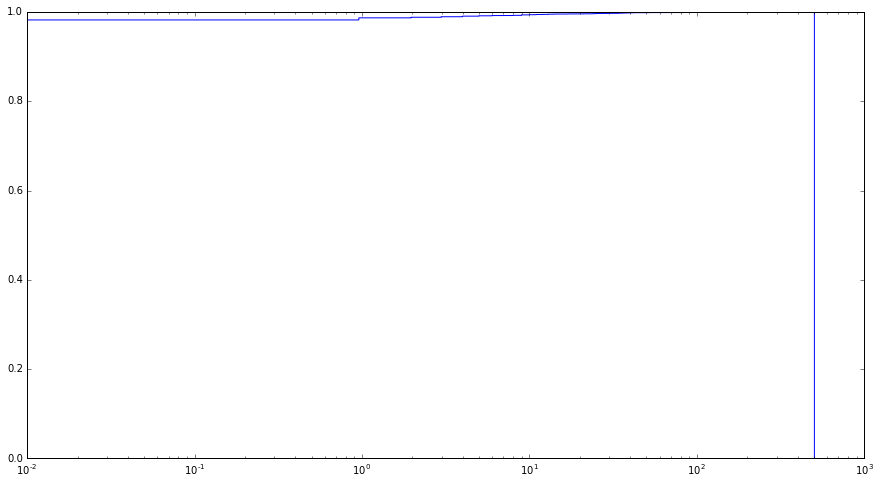

In [241]:
#CDF    
myHist1 = plt.hist(duration_waiting_1stcontainer, 10000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.show()

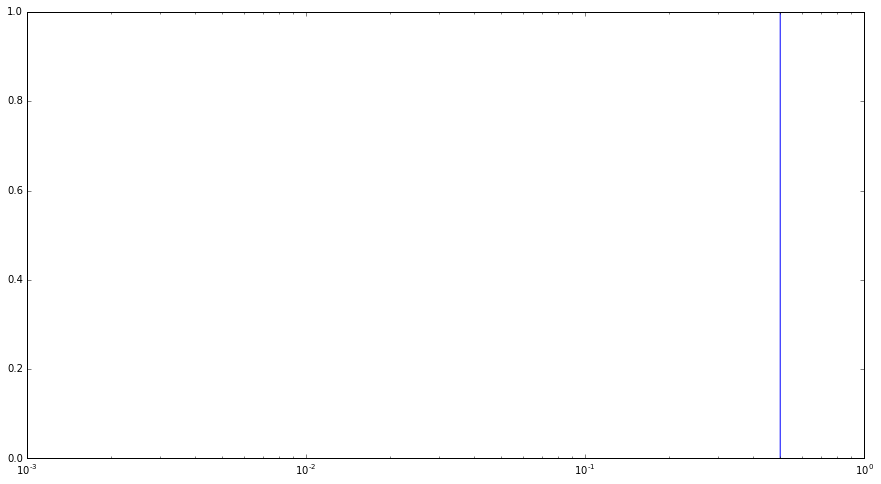

In [242]:
myHist2 = plt.hist(duration_waiting_aftersubmit, 1000, normed=True, cumulative=True, histtype="step")
plt.xscale('log')
plt.show()

In [ ]:
#How many percentage that each user using on the cluster?
#For one user, how did they reserver and how did they actually use the resource (filter the above question)
#How one container evolving during its period
#  + plot figure on all resource for one container

In [ ]:
%matplotlib inline
SnapshotDFFiltered = SnapshotDFSorted

# Filter to select data in a specific time period
startperiod = 1467640800000
endperiod =   1467648000000
tmpdf = SnapshotDFFiltered[(SnapshotDFFiltered.start <= startperiod)] 
tmpdf = tmpdf[(tmpdf.end >= startperiod)]
if tmpdf.empty:
  new_start = startperiod #no container running across this point
else:
  new_start = tmpdf.start.min()
tmpdf = SnapshotDFFiltered[(SnapshotDFFiltered.start <= endperiod)]
tmpdf = tmpdf[(tmpdf.end >= endperiod)]
if tmpdf.empty:
  new_end = endperiod #no container running across this point
else:
  new_end = tmpdf.end.max()
SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.start >= new_start)]
SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.end <= new_end)]

# Filter to remove containers with no informaction of the node, or to select specific nodes
# SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]

# Filter to select specific nodes
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.node != 'svr05.spo:45454')]

# Filter to select specific apps
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.app == 'application_1466697692331_3253')]

# Filter to select specific user
#SnapshotDFFiltered = SnapshotDFFiltered[(SnapshotDFFiltered.appowner == 'astrolog')]

# get list of applications
application_list = SnapshotDFFiltered.app.unique().tolist()
# limit number of app to draw
#head=0
#tail=200
#application_list = application_list[head:tail]
#cumtmpdf = pd.DataFrame()
#for app in application_list:
#  tmpdf = SnapshotDFFiltered[(SnapshotDFFiltered.app == app)]
#  cumtmpdf = cumtmpdf.append(tmpdf)
#SnapshotDFFiltered = cumtmpdf
                             
# get list of users
user_list = SnapshotDFFiltered.appowner.unique().tolist()
print("There are %d users in the trace" % len(user_list))

'''FOR CPU'''
SnapshotDFFiltered_group_node = SnapshotDFFiltered.groupby("node")
total_phy_CPU = SnapshotDFFiltered_group_node.n_CPU.mean().sum() #assume capacity has no change
total_rsrv_CPU = SnapshotDFFiltered_group_node.CPU_rsrv.mean().sum() #assume capacity has no change
print('Total physical cores in these nodes: %s cores' % total_phy_CPU)
print('Total virtual cores reserved for YARN in these nodes: %s cores' % total_rsrv_CPU)

# create vector zero
snapshot_starttime = SnapshotDFFiltered.start.min()    # overwrite the starting point after filter
snapshot_endtime =  SnapshotDFFiltered.end.max()     # overwrite the end point after filter
rescaled_snapshot_starttime = snapshot_starttime / 1000
rescaled_snapshot_endtime = snapshot_endtime / 1000
rescaled_snapshot_duration = rescaled_snapshot_endtime - rescaled_snapshot_starttime
time = np.linspace(rescaled_snapshot_starttime, rescaled_snapshot_endtime-1,rescaled_snapshot_duration)
zero_vector = pd.Series(np.linspace(0, 0,rescaled_snapshot_duration), index=time)
base_vector_cpu_resv = zero_vector
base_vector_cpu_actl = zero_vector
base_vector_mem_resv = zero_vector
base_vector_mem_actl = zero_vector
print(snapshot_starttime)
print(snapshot_endtime)

phy_CPU = np.linspace(total_phy_CPU,total_phy_CPU,rescaled_snapshot_duration)
rsrv_CPU = np.linspace(total_rsrv_CPU,total_rsrv_CPU,rescaled_snapshot_duration)
phy_CPU = pd.Series(phy_CPU,index=time)
rsrv_CPU = pd.Series(rsrv_CPU,index=time)

'''FOR MEMORY'''
total_phy_mem = SnapshotDFFiltered_group_node.n_mem.mean().sum() #assume capacity has no change
total_rsrv_mem = SnapshotDFFiltered_group_node.mem_rsrv.mean().sum() #assume capacity has no change
# convert from KB to GB
total_phy_mem = float(total_phy_mem) / (1024*1024)
total_rsrv_mem = float(total_rsrv_mem) / (1024*1024)
print('Total physical memory in these nodes: %s GBs' % total_phy_mem)
print('Total memory reserved for YARN in these nodes: %s GBs' % total_rsrv_mem)

phy_mem = np.linspace(total_phy_mem,total_phy_mem,rescaled_snapshot_duration)
rsrv_mem = np.linspace(total_rsrv_mem,total_rsrv_mem,rescaled_snapshot_duration)
phy_mem = pd.Series(phy_mem,index=time)
rsrv_mem = pd.Series(rsrv_mem,index=time)

i = 0
user_resv_cpu = []
user_actl_cpu = []
user_resv_mem = []
user_actl_mem = []
user_index = 0
for user in user_list:
  user_cr_data = zero_vector
  user_ca_data = zero_vector
  user_mr_data = zero_vector
  user_ma_data = zero_vector
  for application in application_list:
    i = i + 1
    update_progress(float(i)/(len(application_list)*len(user_list)))
    for index in SnapshotDFFiltered.index:
      if SnapshotDFFiltered.loc[index,'app'] == application and SnapshotDFFiltered.loc[index,'appowner'] == user:
        # get CPU allocated for that container
        container_starttime = SnapshotDFFiltered.loc[index,'start']
        container_endtime = SnapshotDFFiltered.loc[index,'end']
        rescaled_container_starttime = int(container_starttime) / 1000
        rescaled_container_endtime = int(container_endtime) / 1000
        container_duration = rescaled_container_endtime - rescaled_container_starttime
        ###### CPU Reservation
        container_cpu_value = np.linspace(SnapshotDFFiltered.loc[index,'CPU'],
                                    SnapshotDFFiltered.loc[index,'CPU'],
                                    container_duration)
        container_time_index = np.linspace(rescaled_container_starttime,
                                           rescaled_container_endtime-1,
                                           container_duration)
        container_cpu_resv_data = pd.Series(container_cpu_value, index=container_time_index)
        # checking if all points in container data belongs to the snapshot timeframe
        #check = set(container_time_index) - set(time)
        #if len(check): #not empty
        #  print(index)
        #  raise Exception("Error, data point's mismatch")
        ###### actual CPU used '''
        actual_cpu_use = get_cpu_actual_use(index,snapshot_dataframe, snapshot_cpu_profile)
        actual_cpu_use = actual_cpu_use.tolist()
        '''because the return may have lengh longer, we generate the container_time_index again'''
        container_cpu_time_index = np.linspace(rescaled_container_starttime,
                                               rescaled_container_starttime+(len(actual_cpu_use)-1),
                                               len(actual_cpu_use))
        container_cpu_actl_data = pd.Series(actual_cpu_use, index=container_cpu_time_index)
        # checking if all points in container data belongs to the snapshot timeframe
        check = set(container_cpu_time_index) - set(time)
        if len(check): #not empty
          print(index)
        #  raise Exception("Error, data point's mismatch")
        ####### memory reservation
        mem = float(SnapshotDFFiltered.loc[index,'mem']) / (1024*1024)
        container_mem_value = np.linspace(mem,mem,container_duration)
        container_mem_resv_data = pd.Series(container_mem_value, index=container_time_index)
        ####### actual memory
        actual_mem_use = get_mem_actual_use(index,snapshot_dataframe, snapshot_mem_profile)
        actual_mem_use = actual_mem_use.tolist()
        actual_mem_use = [x / (1024*1024*1024) for x in actual_mem_use]
        '''because the return may have lengh longer, we generate the container_time_index again'''
        container_mem_time_index = np.linspace(rescaled_container_starttime,
                                         rescaled_container_starttime+len(actual_mem_use)-1,
                                         len(actual_mem_use))
        container_mem_actl_data = pd.Series(actual_mem_use, index=container_mem_time_index)
        # checking if all points in container data belongs to the snapshot timeframe
        #check = set(container_mem_time_index) - set(time)
        #if len(check): #not empty
        #  raise Exception("Error, data point's mismatch")        
        # matching the container data with the length of the snapshot
        container_cpu_resv_data = container_cpu_resv_data + zero_vector
        container_cpu_resv_data = container_cpu_resv_data.fillna(0)
        container_cpu_actl_data = container_cpu_actl_data + zero_vector
        container_cpu_actl_data = container_cpu_actl_data.fillna(0)
        container_mem_resv_data = container_mem_resv_data + zero_vector
        container_mem_resv_data = container_mem_resv_data.fillna(0)
        container_mem_actl_data = container_mem_actl_data + zero_vector
        container_mem_actl_data = container_mem_actl_data.fillna(0)
        # create drawing vector based on base_vector
        user_cpu_resv_data = container_cpu_resv_data #for stackplot
        user_cpu_actl_data = container_cpu_actl_data #for stackplot
        user_mem_resv_data = container_mem_resv_data #for stackplot
        user_mem_actl_data = container_mem_actl_data #for stackplot
        container_cpu_resv_data = container_cpu_resv_data + base_vector_cpu_resv #add up new data
        base_vector_cpu_resv = container_cpu_resv_data # update base_vector for next iteration
        container_cpu_actl_data = container_cpu_actl_data + base_vector_cpu_actl #add up new data
        base_vector_cpu_actl = container_cpu_actl_data # update base_vector for next iteration
        container_mem_resv_data = container_mem_resv_data + base_vector_mem_resv #add up new data
        base_vector_mem_resv = container_mem_resv_data # update base_vector for next iteration
        container_mem_actl_data = container_mem_actl_data + base_vector_mem_actl #add up new data
        base_vector_mem_actl = container_mem_actl_data # update base_vector for next iteration
        # for stackplot
        user_cpu_resv_data = user_cpu_resv_data + user_cr_data
        user_cr_data = user_cpu_resv_data
        user_cpu_actl_data = user_cpu_actl_data + user_ca_data
        user_ca_data = user_cpu_actl_data
        user_mem_resv_data = user_mem_resv_data + user_mr_data
        user_mr_data = user_mem_resv_data
        user_mem_actl_data = user_mem_actl_data + user_ma_data
        user_ma_data = user_mem_actl_data
  user_resv_cpu.insert(user_index,user_cr_data)
  user_actl_cpu.insert(user_index,user_ca_data)
  user_resv_mem.insert(user_index,user_mr_data)
  user_actl_mem.insert(user_index,user_ma_data)
  user_index += 1
resv_cpu = base_vector_cpu_resv
actl_cpu = base_vector_cpu_actl
resv_mem = base_vector_mem_resv
actl_mem = base_vector_mem_actl

There are 6 users in the trace
Total physical cores in these nodes: 144.0 cores
Total virtual cores reserved for YARN in these nodes: 144.0 cores
1.4676407135e+12
1.46764857103e+12
Total physical memory in these nodes: 377.991531372 GBs
Total memory reserved for YARN in these nodes: 324.0 GBs
Percent: [----------] 0.0283929585463% container_e88_1467203595416_6297_01_000001
container_e88_1467203595416_6297_01_000002
Percent: [----------] 0.0851788756388% container_e88_1467203595416_6299_01_000001
container_e88_1467203595416_6299_01_000002
container_e88_1467203595416_6299_01_000003
container_e88_1467203595416_6299_01_000004
container_e88_1467203595416_6299_01_000005
container_e88_1467203595416_6299_01_000006
container_e88_1467203595416_6299_01_000007
container_e88_1467203595416_6299_01_000008
container_e88_1467203595416_6299_01_000009
container_e88_1467203595416_6299_01_000010
container_e88_1467203595416_6299_01_000011
container_e88_1467203595416_6299_01_000012
container_e88_146720359541

In [65]:
fig_cpu = plt.figure(figsize=(12,8))
ax_cpu = fig_cpu.add_subplot(111)
ax_cpu.plot(phy_CPU,'-b')
ax_cpu.plot(rsrv_CPU,'-g')
ax_cpu.plot(resv_cpu,'-r')
ax_cpu.plot(actl_cpu,'-y')
ax_cpu.axis([time[0],time[len(time)-1],0,160])
ax_cpu.set_ylabel('Number of cores')
ax_cpu.set_xlabel('Timestamps')
ax_cpu.set_title('Cluster CPU Usage')
ax_cpu.legend(['cluster capacity', 'YARN quota','CPU reservation','CPU utilisation'])
ax_cpu.show()

fig_mem = plt.figure(figsize=(12,8))
ax_mem = fig_mem.add_subplot(111)
ax_mem.plot(phy_mem,'-b')
ax_mem.plot(rsrv_mem,'-g')
ax_mem.plot(resv_mem,'-r')
ax_mem.plot(actl_mem,'-y')
ax_mem.axis([time[0],time[len(time)-1],0,400])
ax_mem.set_ylabel('Memory in GBs')
ax_mem.set_xlabel('Timestamps')
ax_mem.set_title('Cluster Memory Usage')
ax_mem.legend(['cluster capacity', 'YARN quota','MEM reservation','MEM utilisation'])
ax_mem.show()

NameError: name 'phy_CPU' is not defined

In [33]:
resv_mem

1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
1.467641e+09    NaN
1.467641e+09    0.0
               ... 
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN
1.467649e+09    0.0
1.467649e+09    NaN


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

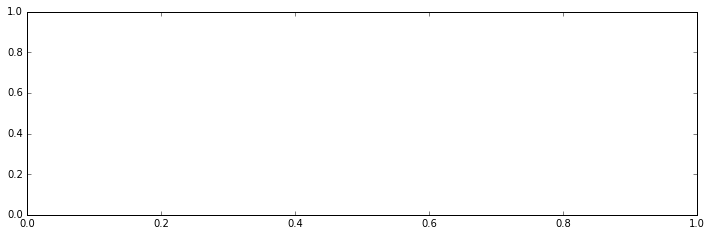

In [32]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(211)
ax1.stackplot(time,user_resv_cpu)
ax1.legend(user_list)
ax1.axis([time[0],time[len(time)-1],0,140])
ax1.set_ylabel('Number of cores')
ax1.set_xlabel('Timestamps')
ax1.set_title('CPU reservation')


ax2 = fig1.add_subplot(212)
ax2.stackplot(time,user_actl_cpu)
ax2.legend(user_list)
ax2.axis([time[0],time[len(time)-1],0,140])
ax2.set_ylabel('Number of cores')
ax2.set_xlabel('Timestamps')
ax2.set_title('CPU usage')

fig2 = plt.figure(figsize=(12,8))
ax3 = fig2.add_subplot(211)
ax3.stackplot(time,user_resv_mem)
ax3.legend(user_list)
ax3.axis([time[0],time[len(time)-1],0,200])
ax3.set_ylabel('Memory size in GBs')
ax3.set_xlabel('Timestamps')
ax3.set_title('Memory reservation')

ax4 = fig2.add_subplot(212)
ax4.stackplot(time,user_actl_mem)
ax4.legend(user_list)
ax4.axis([time[0],time[len(time)-1],0,200])
ax4.set_ylabel('Memory size in GBs')
ax4.set_xlabel('Timestamps')
ax4.set_title('Memory usage')

In [ ]:
#Calculate who waste the resources, and how much they waste   

In [ ]:
%matplotlib notebook
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.plot_date(actual_mem.index,actual_mem,'y')